In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# credits and installation https://github.com/njchiang/tikhonov.git
from tikhonov.TikhonovRegression import Tikhonov

from sklearn.linear_model import LinearRegression

# Get pcm-dpc/COVID-19 data

In [2]:
def parse_date(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [3]:
italy_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'],
    date_parser=parse_date)

In [4]:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

# https://arxiv.org/pdf/2004.04529.pdf

# https://github.com/Keystone-Strategy/covid19-intervention-data/

# https://coviz.apps.allenai.org/

In [5]:
italy_raw_data

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24 23:59:00,ITA,101,26,127,94,221,0,221,1,7,NaN,NaN,229,4324,NaN,NaN
1,2020-02-25 23:59:00,ITA,114,35,150,162,311,90,93,1,10,NaN,NaN,322,8623,NaN,NaN
2,2020-02-26 23:59:00,ITA,128,36,164,221,385,74,78,3,12,NaN,NaN,400,9587,NaN,NaN
3,2020-02-27 23:59:00,ITA,248,56,304,284,588,203,250,45,17,NaN,NaN,650,12014,NaN,NaN
4,2020-02-28 23:59:00,ITA,345,64,409,412,821,233,238,46,21,NaN,NaN,888,15695,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2020-10-30 23:59:00,ITA,16994,1746,18740,307046,325786,26595,31084,283567,38321,439297.0,208377.0,647674,15568575,9446183.0,NaN
250,2020-10-31 23:59:00,ITA,17966,1843,19809,331577,351386,25600,31758,289426,38618,460502.0,218928.0,679430,15784461,9578462.0,NaN
251,2020-11-01 23:59:00,ITA,18902,1939,20841,357288,378129,26743,29907,292380,38826,474270.0,235065.0,709335,15967918,9695940.0,NaN
252,2020-11-02 23:59:00,ITA,19840,2022,21862,374650,396512,18383,22253,296017,39059,487976.0,243612.0,731588,16103649,9783603.0,NaN


In [6]:
italy_raw_data.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note'],
      dtype='object')

In [7]:
TIMESTEPS = len(italy_raw_data.nuovi_positivi)

## Check data consistency

In [8]:
(italy_raw_data.totale_positivi 
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

True

In [9]:
(italy_raw_data.ricoverati_con_sintomi
 + italy_raw_data.terapia_intensiva
 == italy_raw_data.totale_ospedalizzati).all()

False

In [10]:
(italy_raw_data.totale_ospedalizzati 
+ italy_raw_data.isolamento_domiciliare 
== italy_raw_data.totale_positivi).all()

False

In [11]:
(italy_raw_data.ricoverati_con_sintomi
+ italy_raw_data.terapia_intensiva
+ italy_raw_data.isolamento_domiciliare
== italy_raw_data.totale_positivi).all()

True

In [12]:
(italy_raw_data.ricoverati_con_sintomi
 + italy_raw_data.terapia_intensiva
 + italy_raw_data.isolamento_domiciliare
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

True

# Get Italy: Mobility COVID-19 data

In [13]:
# first url (now 404):
#url = 'https://data.humdata.org/dataset/40a9ea9e-0edb-49f7-a440-6aee3015961b/resource/d5384152-f198-466d-9be8-7f250c4edae9/download/average_network_degree_by_province_20200321_allusers.csv'
# dataset V1 up to march 27:
#url = 'https://ndownloader.figshare.com/files/22613561'
# dataset V2 up to june 26:
url = 'https://data.humdata.org/dataset/40a9ea9e-0edb-49f7-a440-6aee3015961b/resource/04aaa605-2755-4696-9a29-ab9ce3c59c62/download/average_network_degree_2020_01_18_2020_06_26.csv'



italy_mobility_data = pd.read_csv(url)

italy_mobility_data = italy_mobility_data.drop(labels='Unnamed: 0', axis=1)

italy_mobility_data = pd.melt(
    italy_mobility_data, 
    id_vars=['COD_PROV', 'SIGLA', 'NAME_PROV'], 
    value_name='network_degree',
    var_name='date'
)

italy_mobility_data['date'] = pd.to_datetime(italy_mobility_data['date'])

italy_mobility_data = \
    italy_mobility_data.groupby(by=['date']).mean().reset_index().drop(labels='COD_PROV', axis=1)

In [14]:
italy_mobility_data

,date,network_degree
0,2020-01-18,0.050819
1,2020-01-19,0.045722
2,2020-01-20,0.046177
3,2020-01-21,0.048892
4,2020-01-22,0.047412
...,...,...
156,2020-06-22,0.038817
157,2020-06-23,0.039950
158,2020-06-24,0.036669
159,2020-06-25,0.040877


In [15]:
MOBILITY_TIMESTEPS = len(italy_mobility_data.network_degree)

# Smoothing data

## Function `smooth_data`

Data are smoothed by fitting a series to represent the derivative of the original signal and then integrating it back to the original signal, which results in a smoothed one.


Given $y$ the signal to be smoothed, we search for the differential signal $\omega$ such that:
$$y = X\cdot \omega$$
where $X$ is the matrix representing the integration operator:
$$X = \begin{bmatrix} 
1 & 0 & 0 & ... & 0 \\
1 & 1 & 0 & ... & 0 \\
1 & 1 & 1 & ... & 0 \\
... & ... & ... & ...  & ... \\
1 & 1 & ... & ... & 1 \\
\end{bmatrix}
$$

$\omega$ is obtained by minimizing the following cost function:
$$F(\omega) = \left\|y - X\cdot\omega\right\|^2 +\alpha^2 \left\|\Gamma\cdot\omega\right\|^2$$

Hence the derivative is fitted using a Ridge regresssion with a generalized Tikhonov regularization factor:
- $y$: the original signal
- $X$: we choose the the integration matrix, to force the fitted signal to be the derivative one
- $\Gamma$: the Tikhonov regularizaztion matrix, choosen as the second derivative operator
- $\alpha$: the regularization factor

The regularization factor penalizes the noise, forcing the derivative to be a smoothed signal.
Once the derivative is fitted, then the original signal is reconstructed by appliyng again the integral matrix to the differentiated signal. The bigger the alpha factor, the smoother the signal.

## Function `smooth_differentiate`
As a by product of this procedure, we can apply the fit to cumulative data to obtain the daily variations, eg to obtain the "nuovi_positivi" from the "totale_casi"

## Function `filter_matrices`
Integral and derivative matrices are just the matrices that applyed to a signal produce the integral or the derivative. They are built via `np.tril`, `np.ones` and `np.eye`.


In [16]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [17]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [18]:
def smooth_data(y, X, L, alpha):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

In [19]:
italy_raw_data['tamponi_giornalieri'] = (italy_raw_data.tamponi - italy_raw_data.tamponi.shift(1)).fillna(0)
italy_raw_data['tamponi_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.tamponi, 
                                                                      X=INTEGRAL_MATRIX,
                                                                      L=GAMMA,
                                                                      alpha=ALPHA)

TIC R2: 0.9999894879433482


In [20]:
italy_raw_data['dimessi_guariti_giornalieri'] = (italy_raw_data.dimessi_guariti - italy_raw_data.dimessi_guariti.shift(1)).fillna(0)
italy_raw_data['dimessi_guariti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.dimessi_guariti,
                                                                              X=INTEGRAL_MATRIX,
                                                                              L=GAMMA,
                                                                              alpha=ALPHA)

TIC R2: 0.9999694762486493


In [21]:
italy_raw_data['deceduti_giornalieri'] = (italy_raw_data.deceduti - italy_raw_data.deceduti.shift(1)).fillna(0)
italy_raw_data['deceduti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.deceduti,
                                                                       X=INTEGRAL_MATRIX,
                                                                       L=GAMMA,
                                                                       alpha=ALPHA)

TIC R2: 0.9999930729978825


In [22]:
italy_raw_data['nuovi_positivi_smoothed'] = smooth_differentiate(italy_raw_data.totale_casi,
                                                                 X=INTEGRAL_MATRIX,
                                                                 L=GAMMA,
                                                                 alpha=ALPHA)

TIC R2: 0.9999621366837438


In [23]:
filter_columns = [
    'ricoverati_con_sintomi', 'terapia_intensiva',
    'isolamento_domiciliare', 'totale_positivi',
    'dimessi_guariti', 'deceduti', 'tamponi', 'totale_casi'
]

for col in filter_columns:
    italy_raw_data[col+'_smoothed'] = smooth_data(y=italy_raw_data[col],
                                              X=INTEGRAL_MATRIX,
                                              L=GAMMA,
                                              alpha=ALPHA)

TIC R2: 0.9997265733801088
TIC R2: 0.999840086358943
TIC R2: 0.9998161378830097
TIC R2: 0.999842467665517
TIC R2: 0.9999694762486493
TIC R2: 0.9999930729978825
TIC R2: 0.9999894879433482
TIC R2: 0.9999621366837438


In [24]:
MOBILITIY_INTEGRAL_MATRIX, MOBILITY_SECOND_DERIVATIVE_MATRIX = filter_matrices(MOBILITY_TIMESTEPS)

In [25]:
italy_mobility_data['network_degree_smoothed'] = smooth_data(italy_mobility_data.network_degree,
                                                             X=MOBILITIY_INTEGRAL_MATRIX,
                                                             L=MOBILITY_SECOND_DERIVATIVE_MATRIX,
                                                             alpha=20.)

TIC R2: 0.9494433317815328


# Plot everything

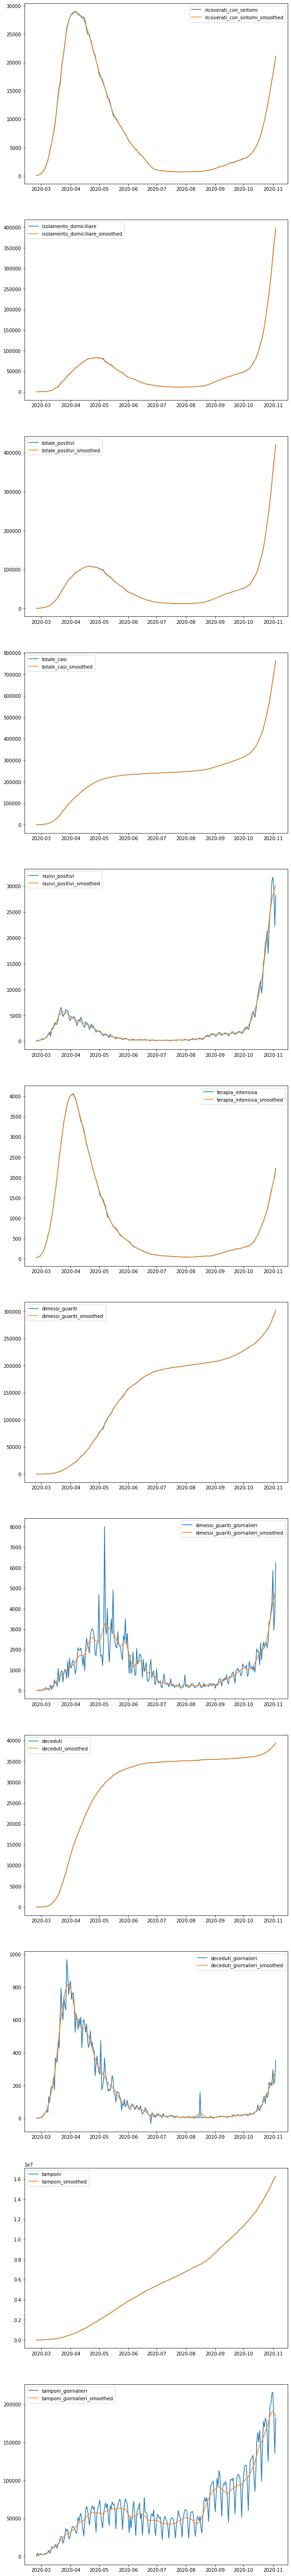

In [26]:
plotcols = [
    'ricoverati_con_sintomi', 
    'isolamento_domiciliare', 'totale_positivi',
    'totale_casi', 'nuovi_positivi',     
    'terapia_intensiva', 
    'dimessi_guariti', 'dimessi_guariti_giornalieri',
    'deceduti', 'deceduti_giornalieri',
    'tamponi', 'tamponi_giornalieri', 
]

fig, axs = plt.subplots(len(plotcols), figsize=(10,100))
for col in plotcols:
    sbp = axs[plotcols.index(col)]
    sbp.plot(italy_raw_data.data, italy_raw_data[col], label=col)
    sbp.plot(italy_raw_data.data, italy_raw_data[col+'_smoothed'], label=col+'_smoothed')
    sbp.legend(fontsize=10)

# Compute the mortality (draft and probably wrong)

In [27]:
def compute_average_ratio(x, y):
    r = x / y
    return np.mean(r), np.std(r)

In [28]:
def compute_offset(s_preceeding, s_following, start = -20, interval = 10):
    crosscorrs =[]
    for shift in range(start, interval):
        crosscorrs.append(
            s_preceeding.corr(s_following.shift(shift))
        )

    return start + crosscorrs.index(max(crosscorrs)), crosscorrs

In [29]:
offset_deceduti_to_nuovi_positivi, cc = compute_offset(
    italy_raw_data.nuovi_positivi_smoothed, italy_raw_data.deceduti_giornalieri_smoothed
)

In [30]:
offset_deceduti_to_nuovi_positivi

-17

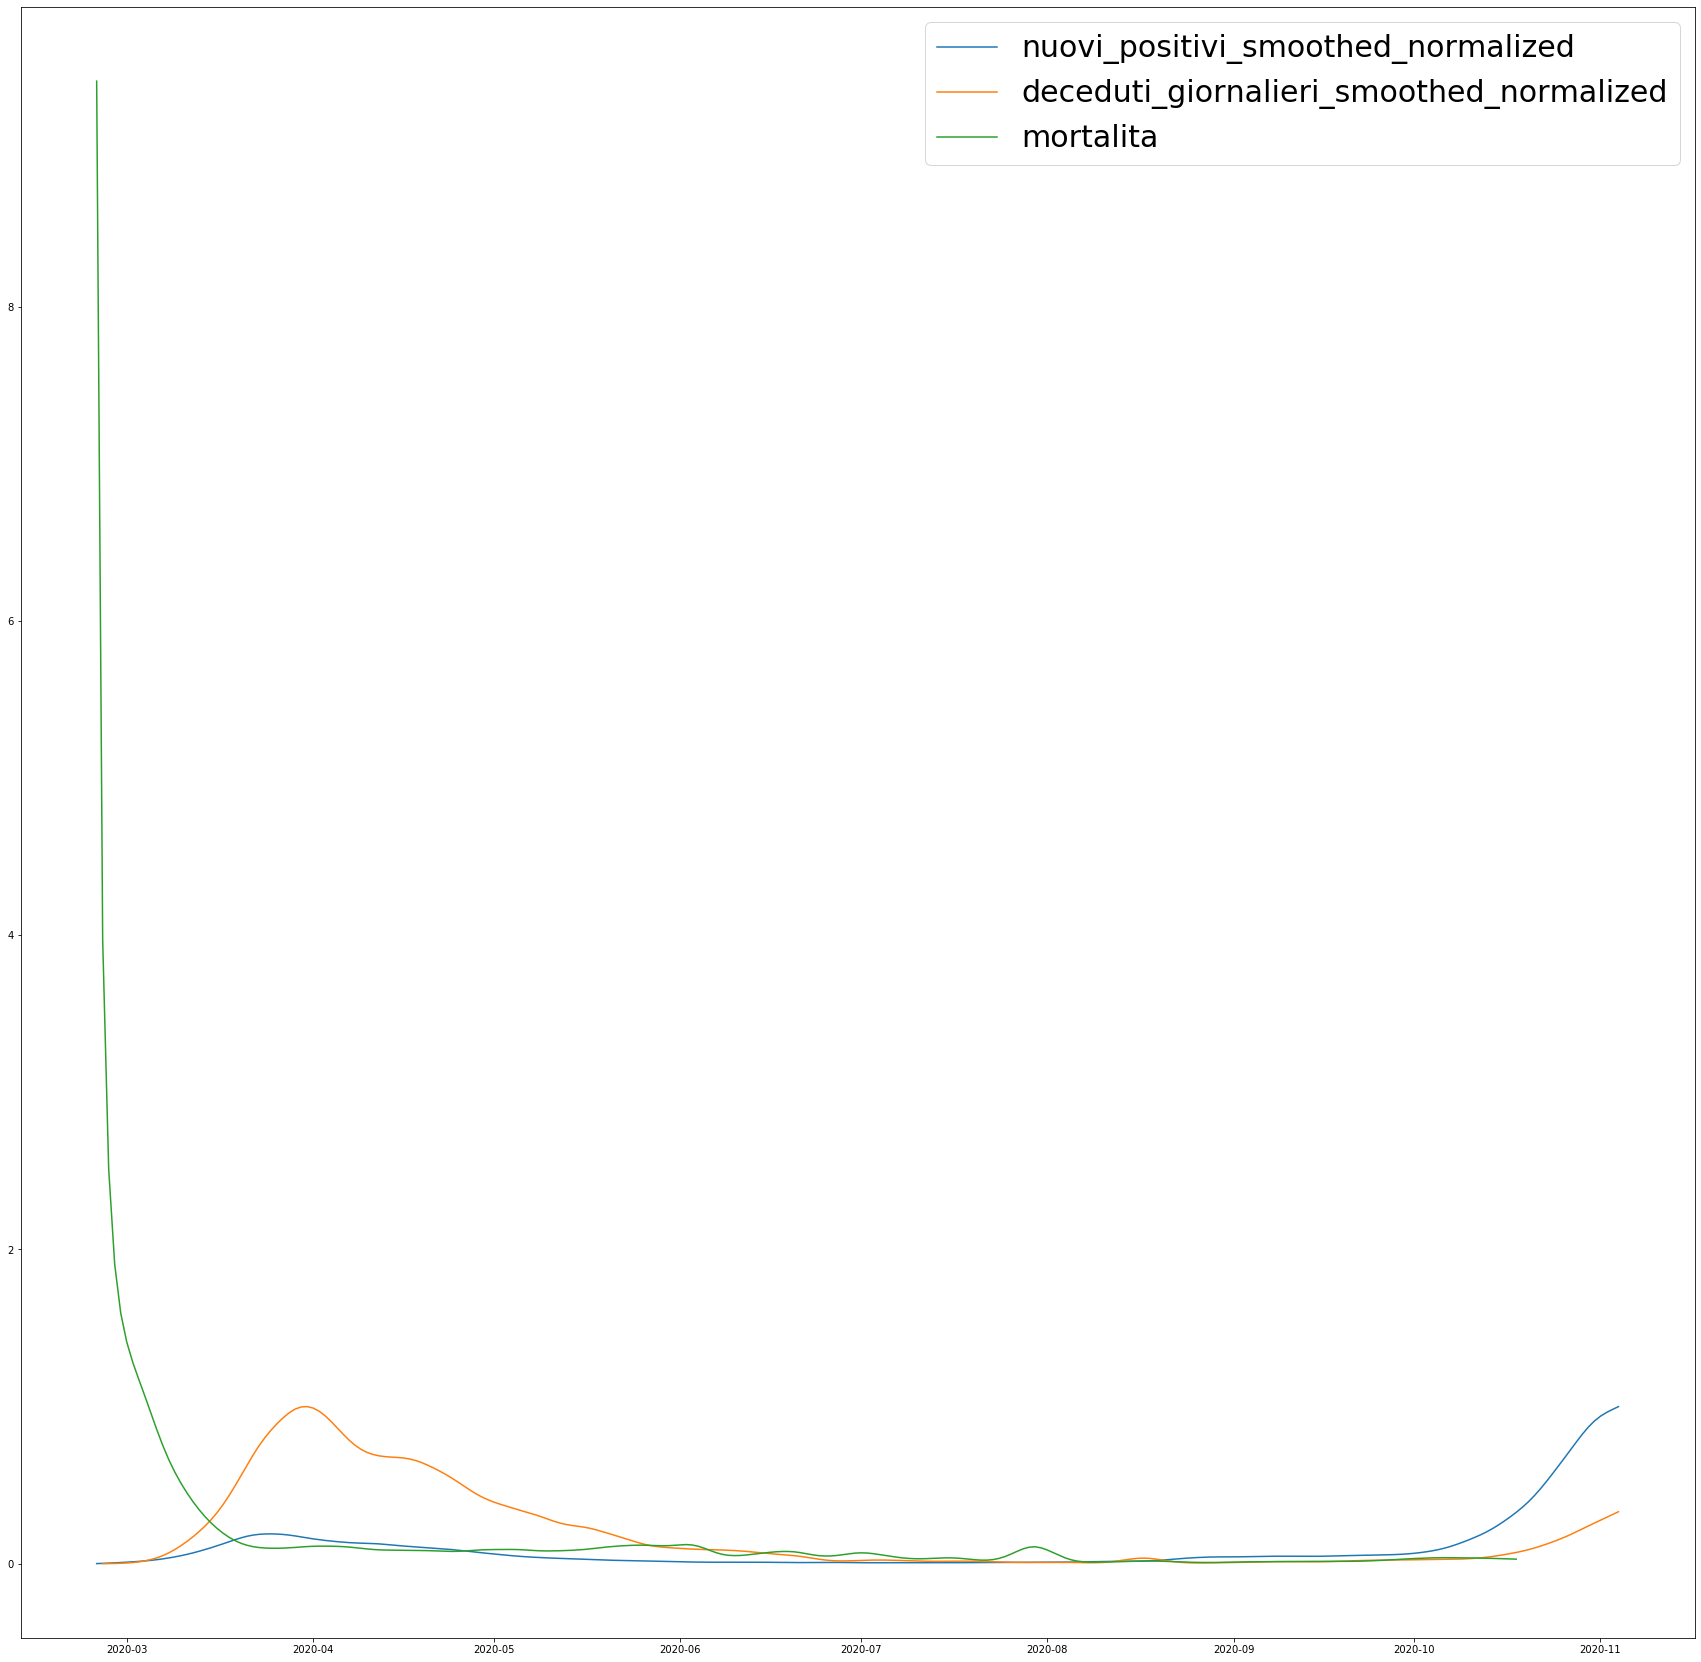

In [31]:
plt.figure(figsize=(30,30))
plt.plot(
    italy_raw_data.data, 
    italy_raw_data.nuovi_positivi_smoothed/italy_raw_data.nuovi_positivi_smoothed.max(), 
    label='nuovi_positivi_smoothed_normalized'
)
plt.plot(
    italy_raw_data.data, 
    italy_raw_data.deceduti_giornalieri_smoothed.shift()/italy_raw_data.deceduti_giornalieri_smoothed.max(), 
    label='deceduti_giornalieri_smoothed_normalized'
)
plt.plot(
    italy_raw_data.data, 
    italy_raw_data.deceduti_giornalieri_smoothed.shift(offset_deceduti_to_nuovi_positivi)/italy_raw_data.nuovi_positivi_smoothed, 
    label='mortalita'
)
plt.legend(fontsize=30)


In [32]:
m, m_e = compute_average_ratio(italy_raw_data.deceduti_giornalieri_smoothed.shift(offset_deceduti_to_nuovi_positivi), italy_raw_data.nuovi_positivi_smoothed)

In [33]:
print(m, m_e)

0.18408004788226118 0.7128692521014455


# Diffusion

## average totale_positivi over previous x days

In [34]:
def moving_average(series, window):
    return series.rolling(window).mean()

## totale_positivi in x days

In [35]:
(italy_raw_data.totale_positivi 
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

True

In [36]:
(
      italy_raw_data.totale_positivi.shift(1)
    - italy_raw_data.dimessi_guariti_giornalieri.shift(0)
    - italy_raw_data.deceduti_giornalieri.shift(0)
    + italy_raw_data.nuovi_positivi.shift(0)
) - italy_raw_data.totale_positivi.shift(0)

0      NaN
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
249    5.0
250    2.0
251    2.0
252    0.0
253    3.0
Length: 254, dtype: float64

In [37]:
def get_totale_positivi_in_window(x, window, smoothed=False):
    postfix = ''
    if smoothed:
        postfix = '_smoothed'
    return (
        (
              x['totale_positivi' + postfix].shift(window + 1)
            - x['dimessi_guariti_giornalieri' + postfix].shift(window)
            - x['deceduti_giornalieri' + postfix].shift(window)
        ) + 
        (
              x['totale_casi' + postfix].shift(0)
            - x['totale_casi' + postfix].shift(window)
        )
    )

In [38]:
get_totale_positivi_in_window(italy_raw_data, 14, smoothed=True)

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
           ...      
249    353506.446987
250    379043.542944
251    405154.259800
252    431688.073237
253    458578.075809
Length: 254, dtype: float64

In [39]:
italy_raw_data['totale_positivi_in_14'] = get_totale_positivi_in_window(italy_raw_data, 14)
italy_raw_data['totale_positivi_in_14_smoothed'] = get_totale_positivi_in_window(italy_raw_data, 14, smoothed=True)

italy_raw_data['totale_positivi_in_28'] = get_totale_positivi_in_window(italy_raw_data, 28)
italy_raw_data['totale_positivi_in_28_smoothed'] = get_totale_positivi_in_window(italy_raw_data, 28, smoothed=True)


No handles with labels found to put in legend.


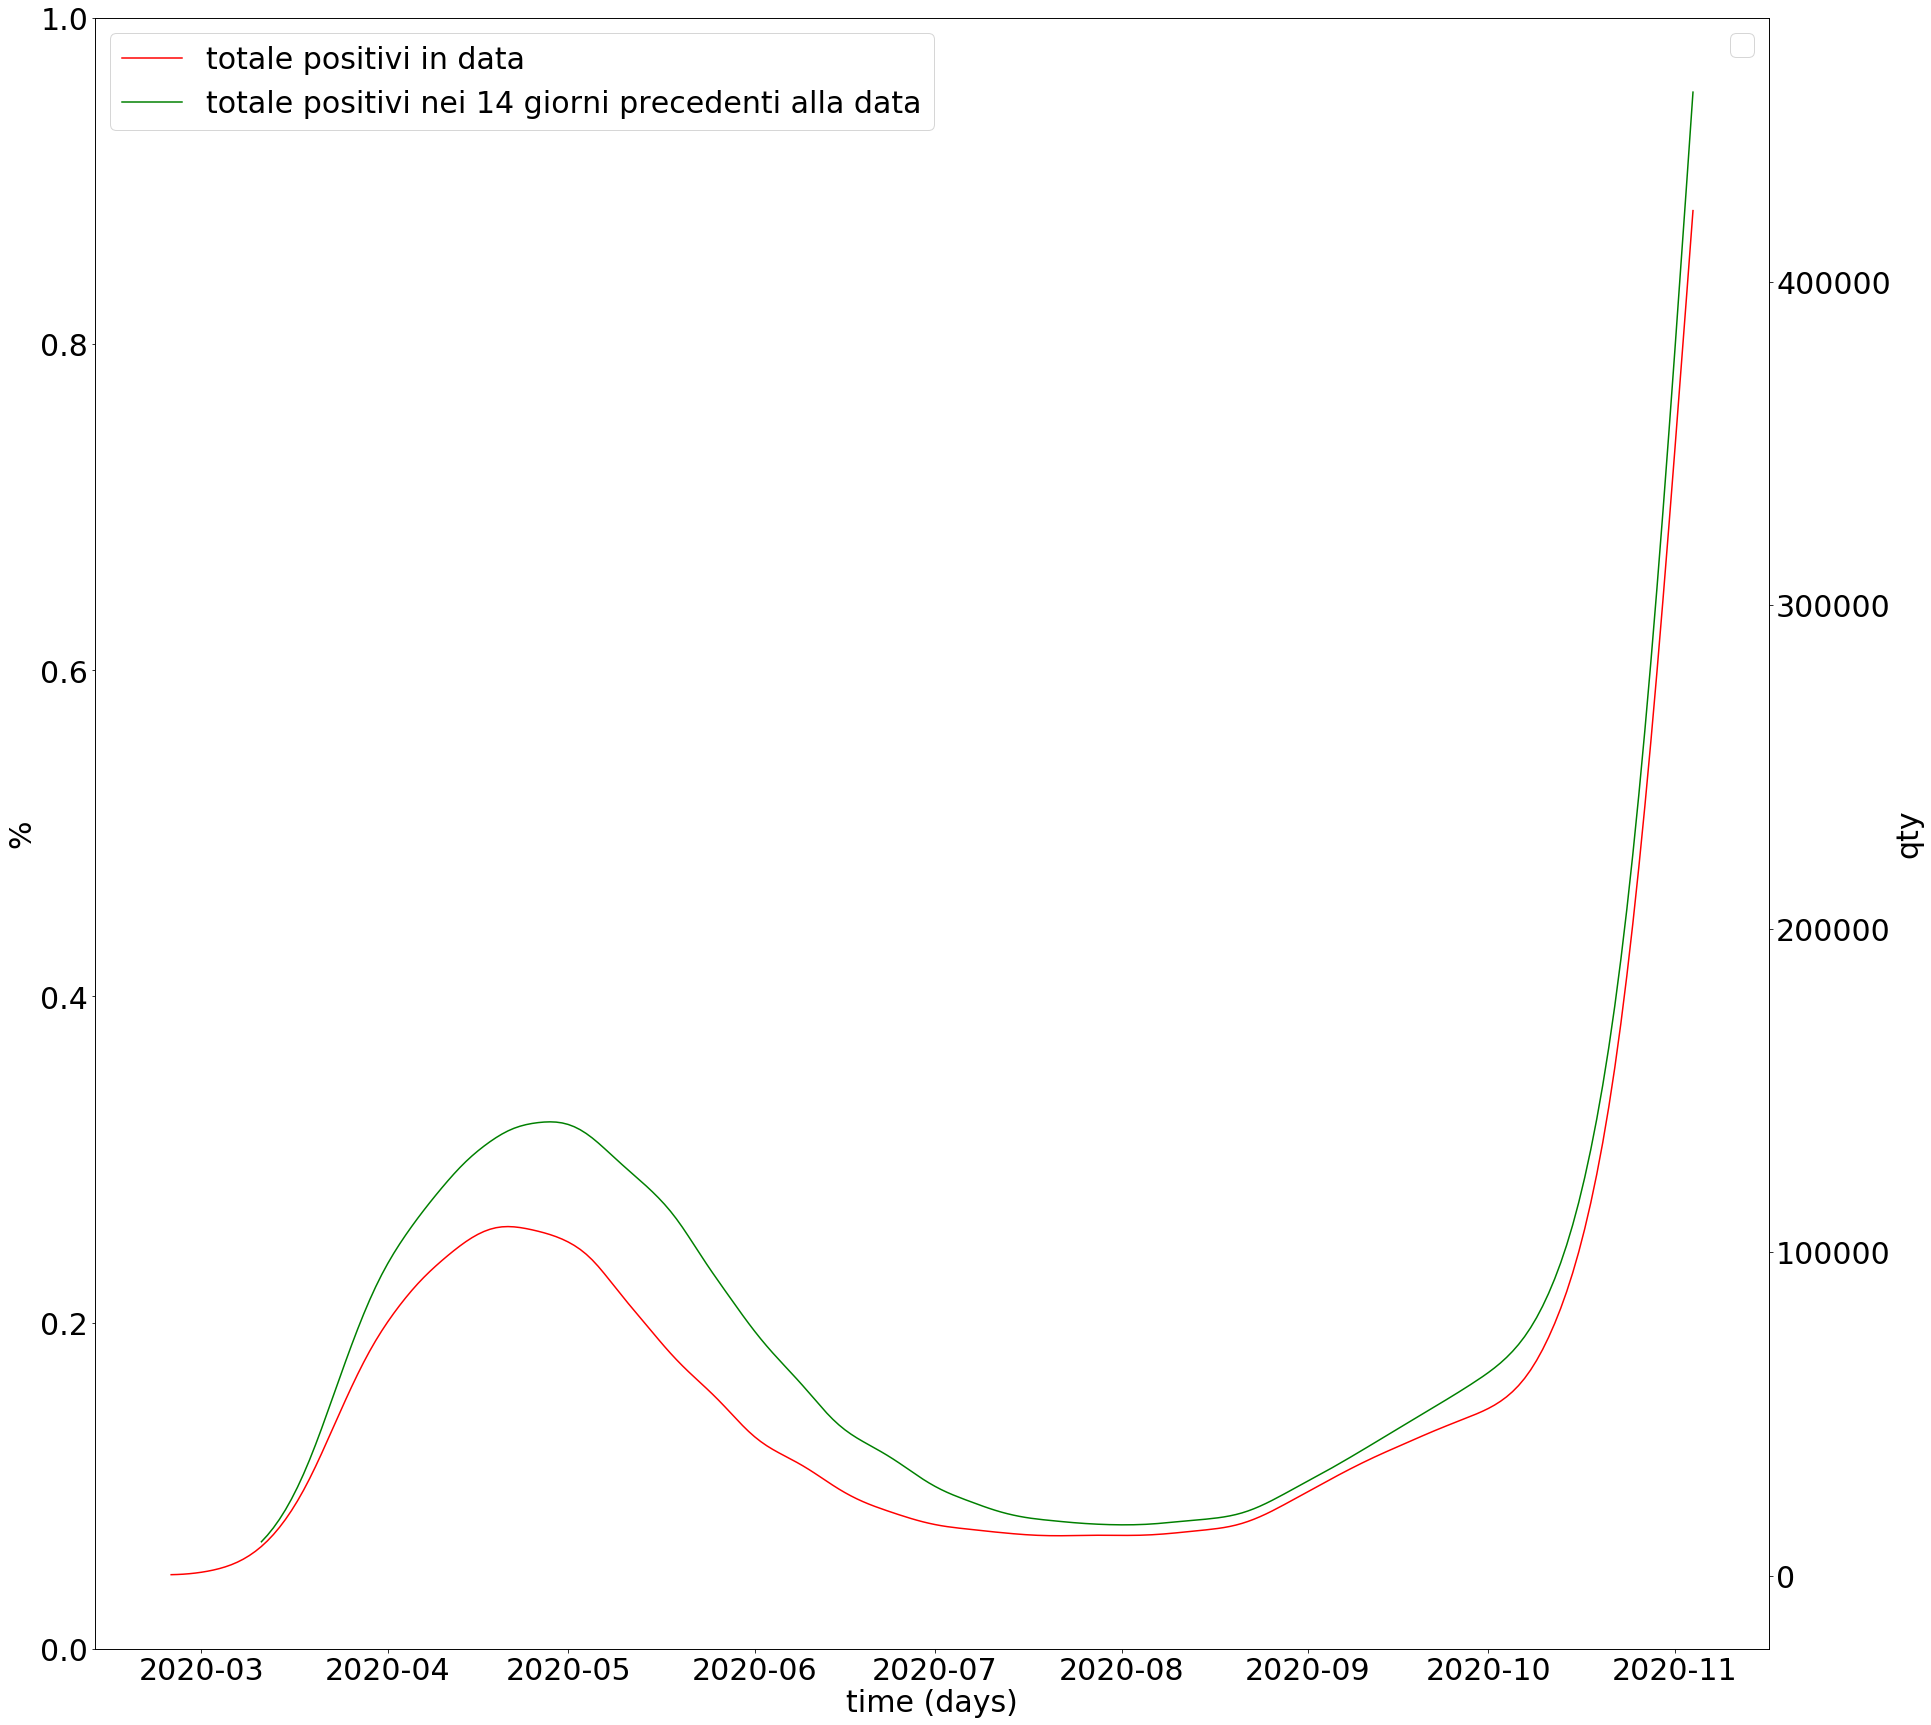

In [40]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,30))

ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)

#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed*100, label='diffusione_su_totale_positivi_in_14_smoothed', color='orange')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=30)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('qty', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed, label='totale positivi in data', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed, label='totale positivi nei 14 giorni precedenti alla data', color='green')

ax2.legend(fontsize=30)

In [41]:

italy_raw_data['diffusione_su_totale_positivi_in_14'] = italy_raw_data.nuovi_positivi/italy_raw_data.totale_positivi_in_14

italy_raw_data['diffusione_su_totale_positivi_in_14_smoothed'] = italy_raw_data.nuovi_positivi_smoothed/italy_raw_data.totale_positivi_in_14_smoothed

In [42]:

italy_raw_data['diffusione_terapia_intensiva_su_totale_positivi_in_14'] = italy_raw_data.terapia_intensiva/italy_raw_data.totale_positivi_in_14

italy_raw_data['diffusione_terapia_intensiva_su_totale_positivi_in_14_smoothed'] = italy_raw_data.terapia_intensiva_smoothed /italy_raw_data.totale_positivi_in_14_smoothed

In [43]:

italy_raw_data['diffusione_deceduti_su_totale_positivi_in_14'] = italy_raw_data.deceduti_giornalieri/italy_raw_data.totale_positivi_in_14

italy_raw_data['diffusione_deceduti_su_totale_positivi_in_14_smoothed'] = italy_raw_data.deceduti_giornalieri_smoothed /italy_raw_data.totale_positivi_in_14_smoothed

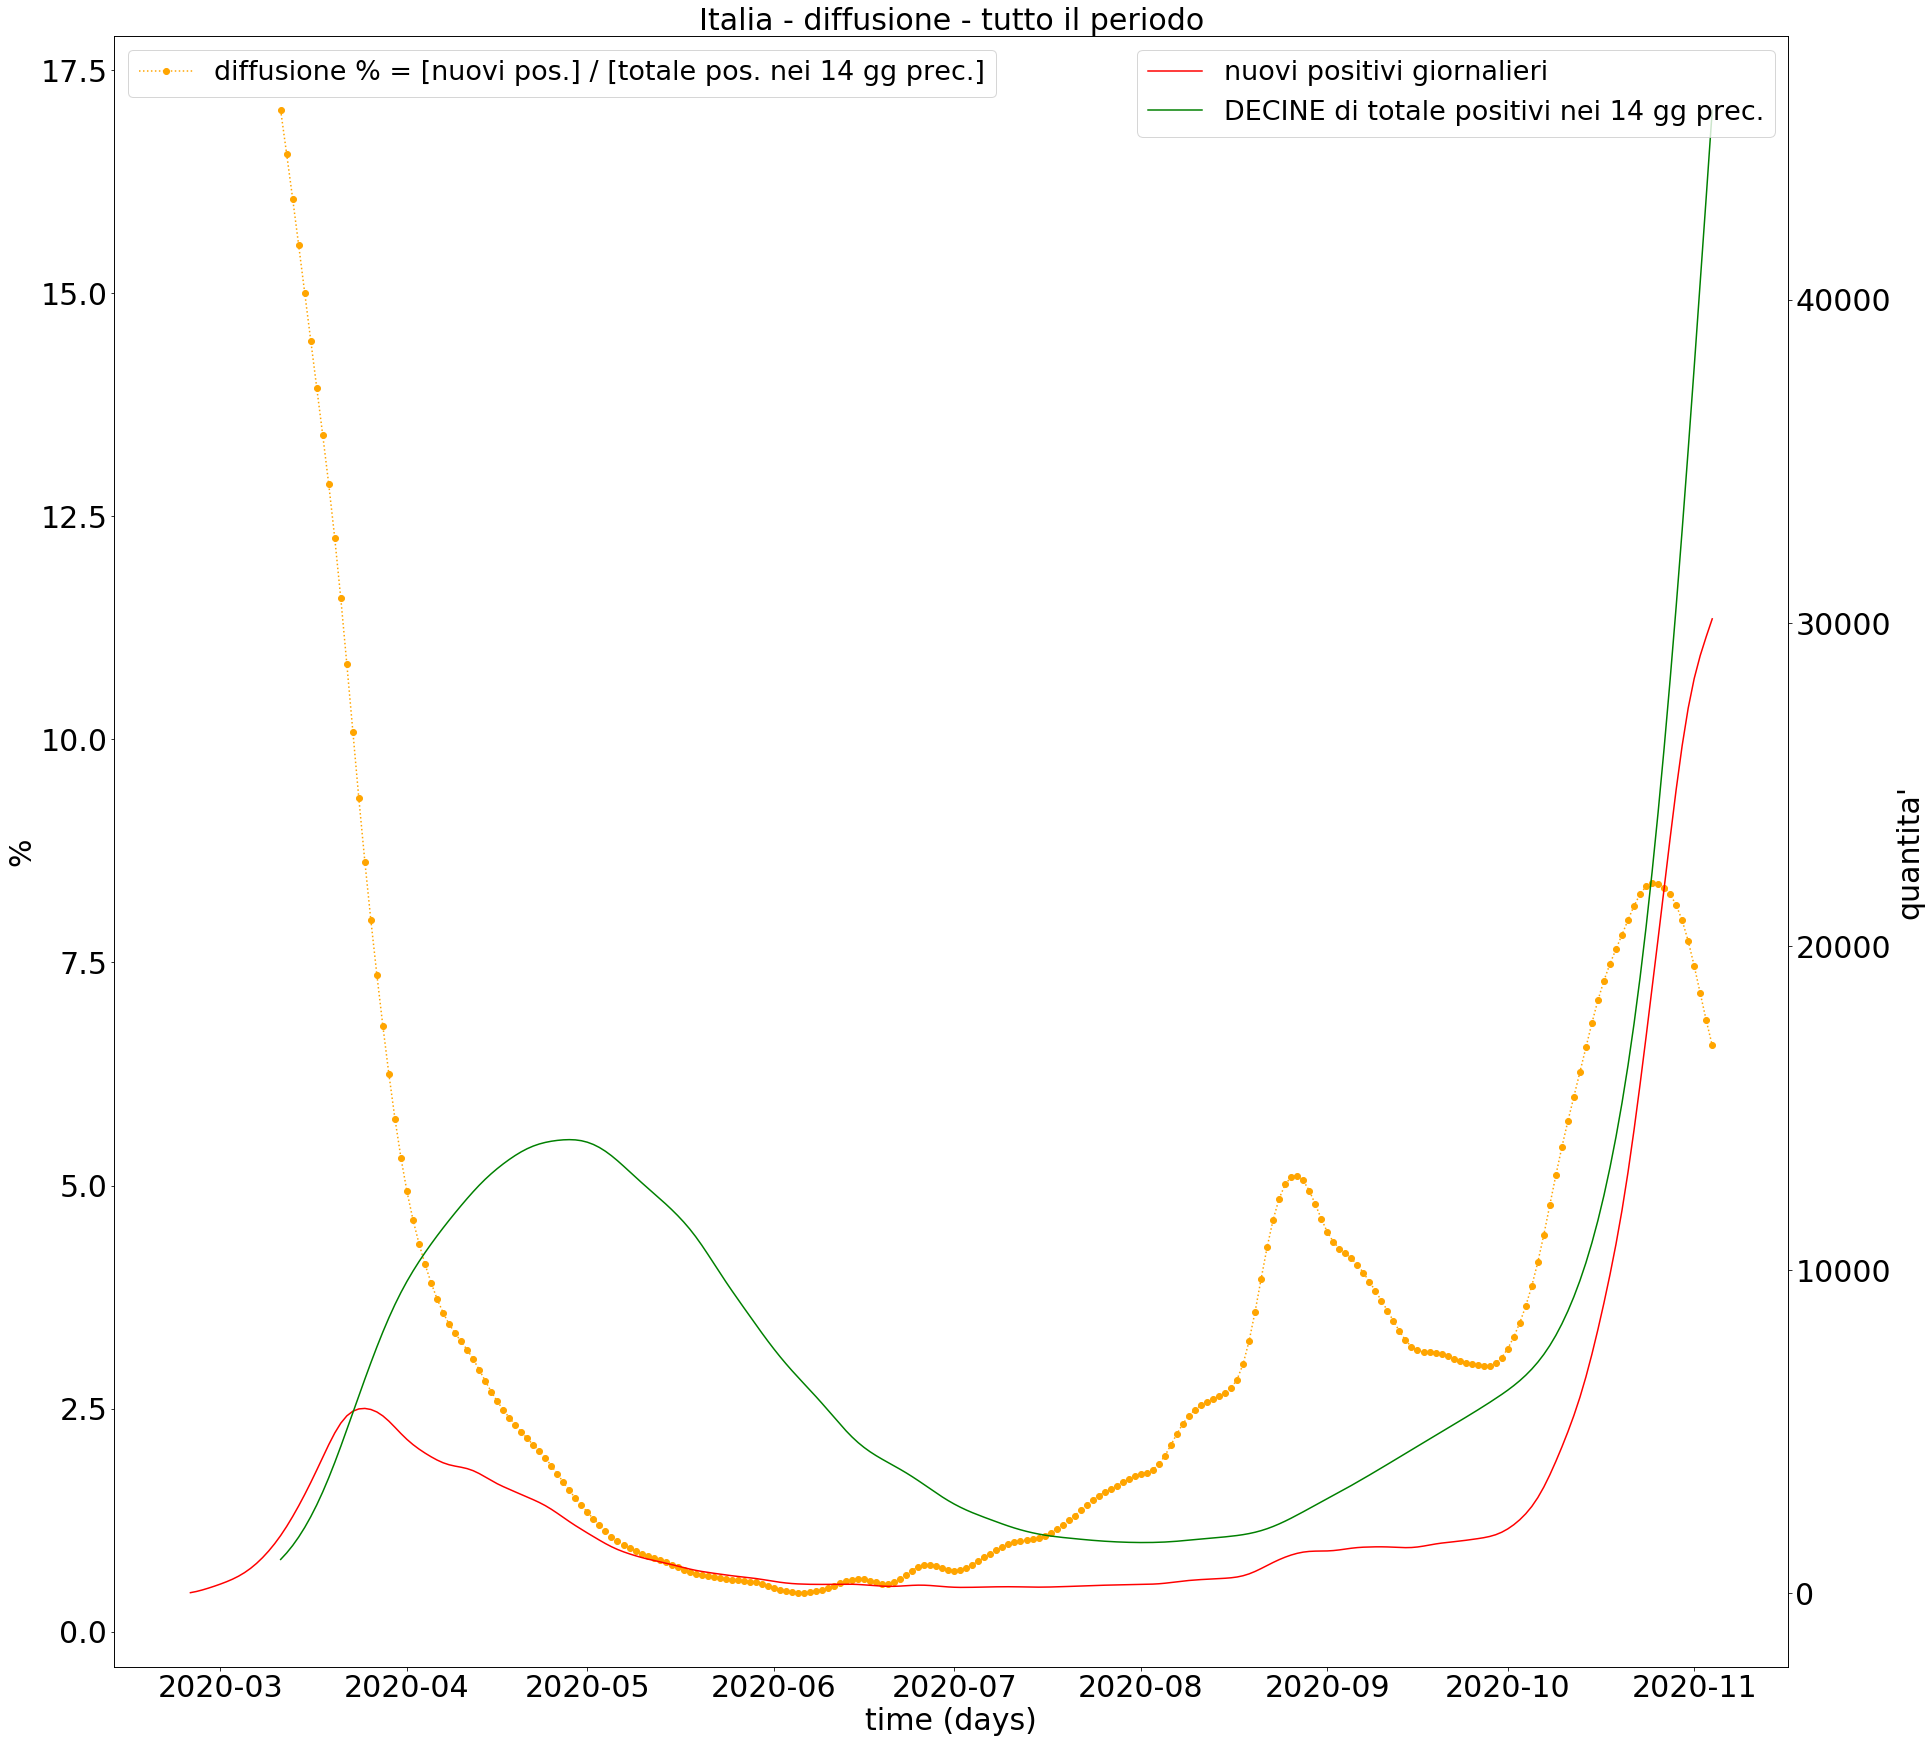

In [44]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,30))
ax1.set_title('Italia - diffusione - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)

ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed*100, label='diffusione % = [nuovi pos.] / [totale pos. nei 14 gg prec.]', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')

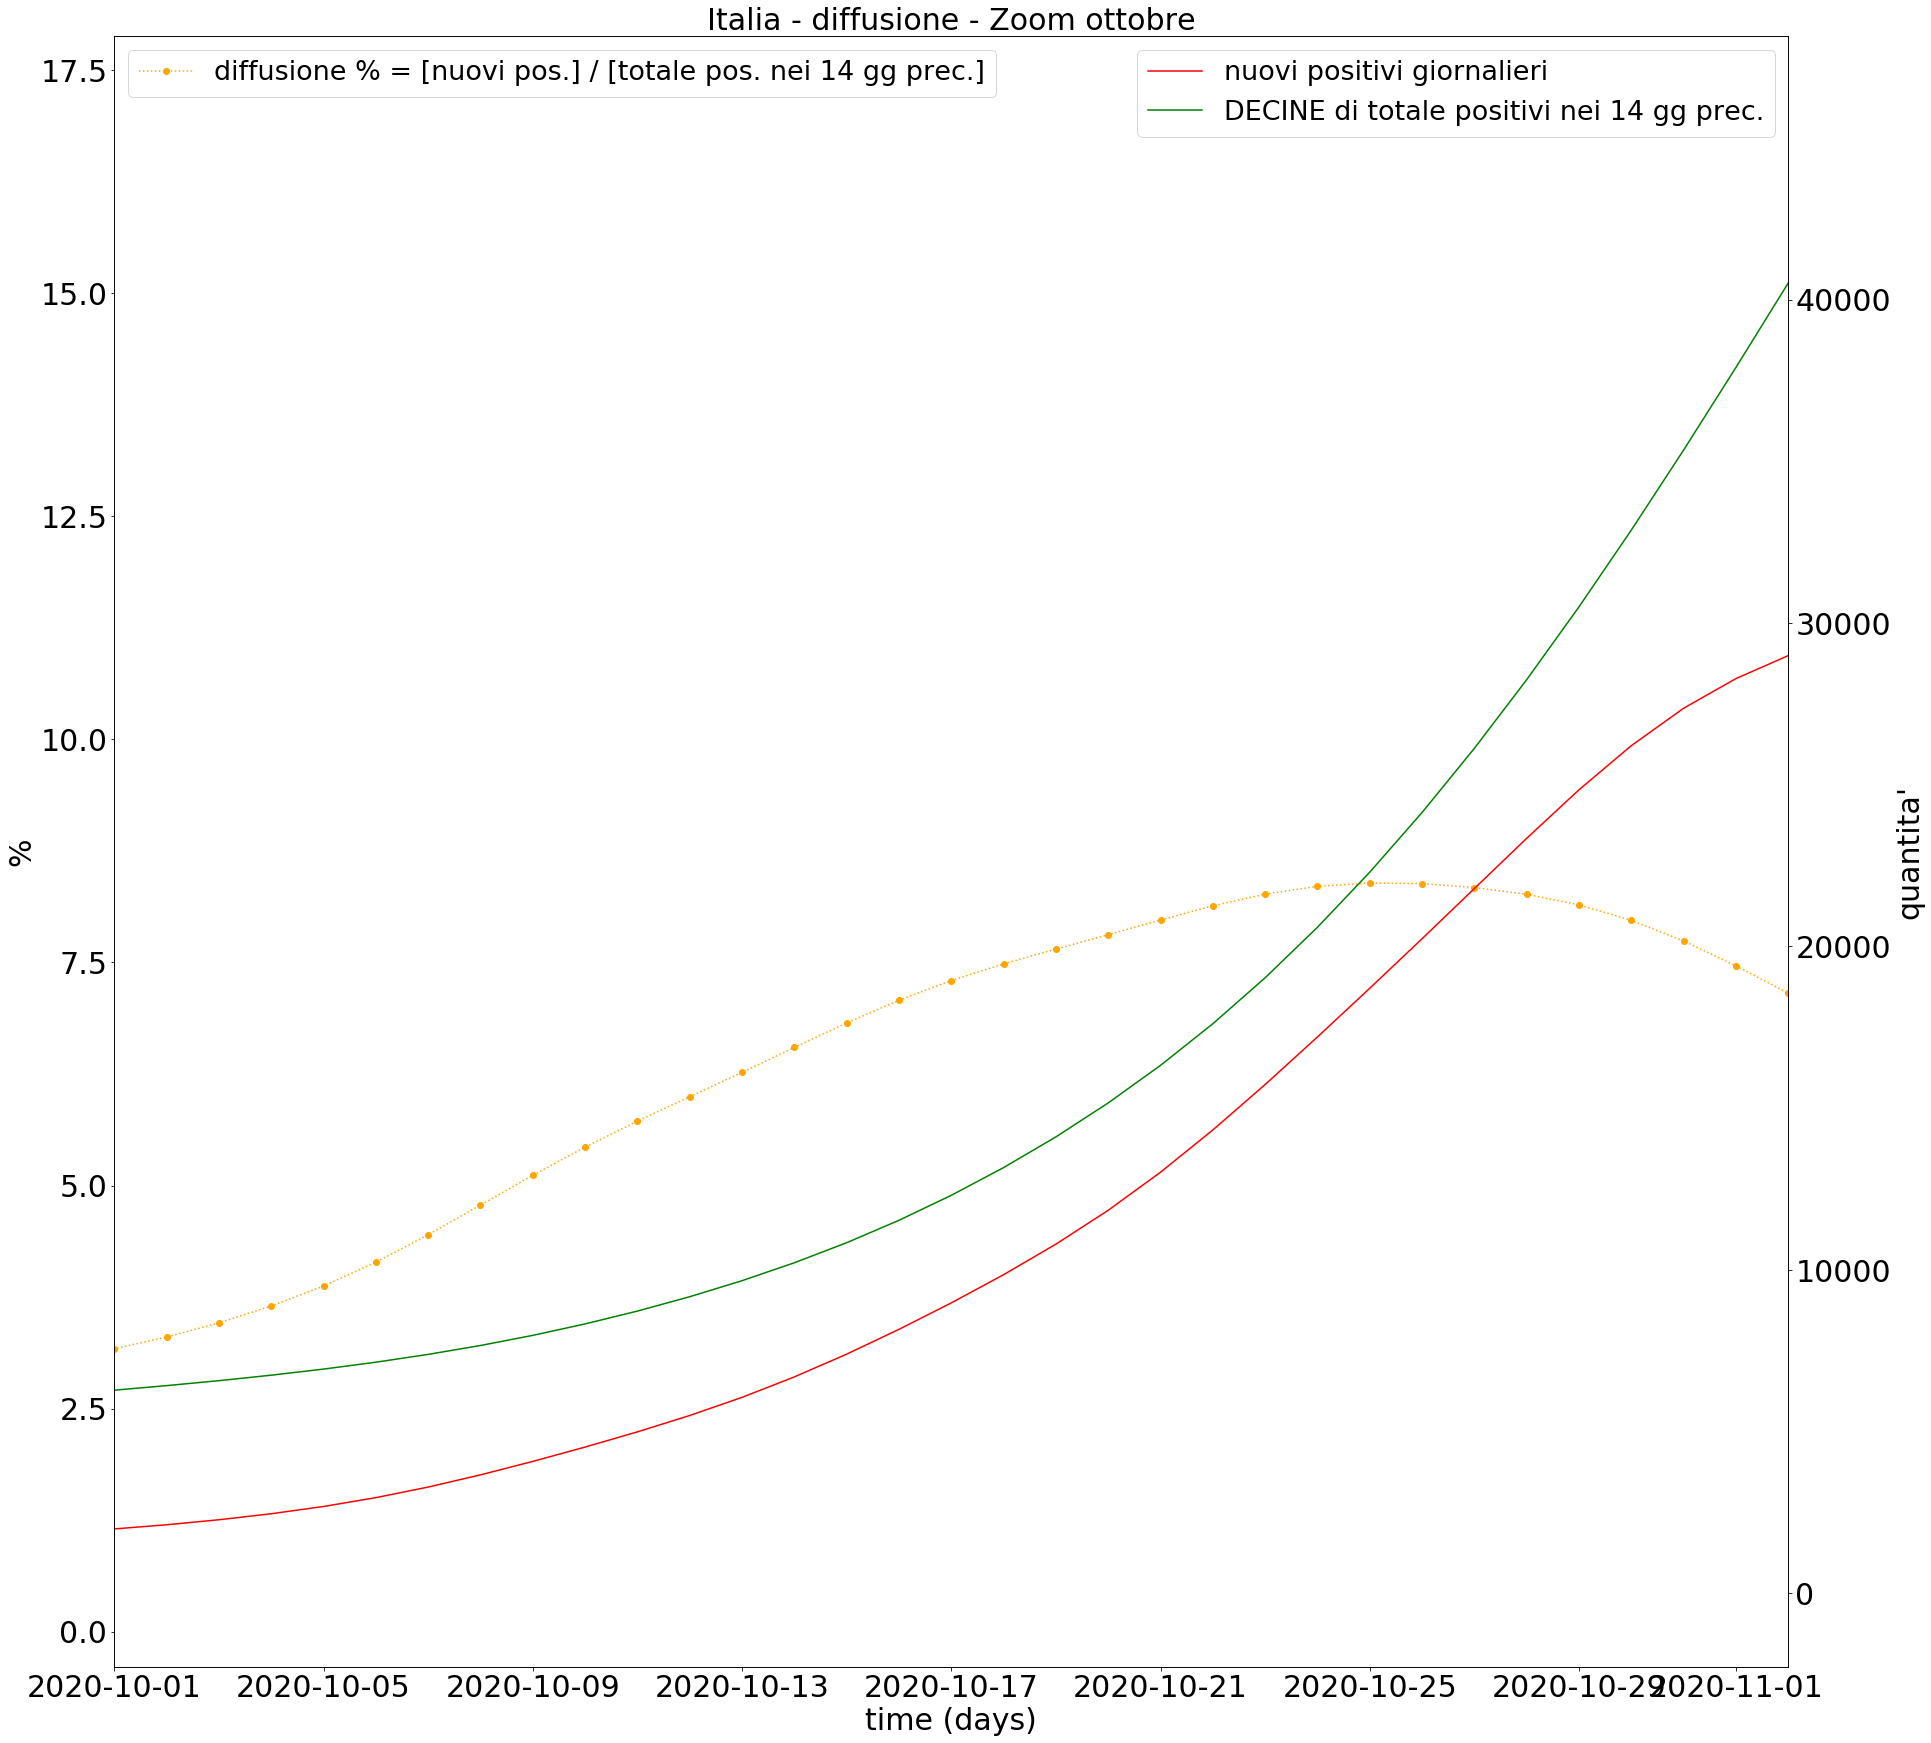

In [45]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,30))
ax1.set_title('Italia - diffusione - Zoom ottobre', fontsize=30)

ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)
ax1.set_xlim(datetime(2020,10,1),datetime(2020,11,2))

ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed*100, label='diffusione % = [nuovi pos.] / [totale pos. nei 14 gg prec.]', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')





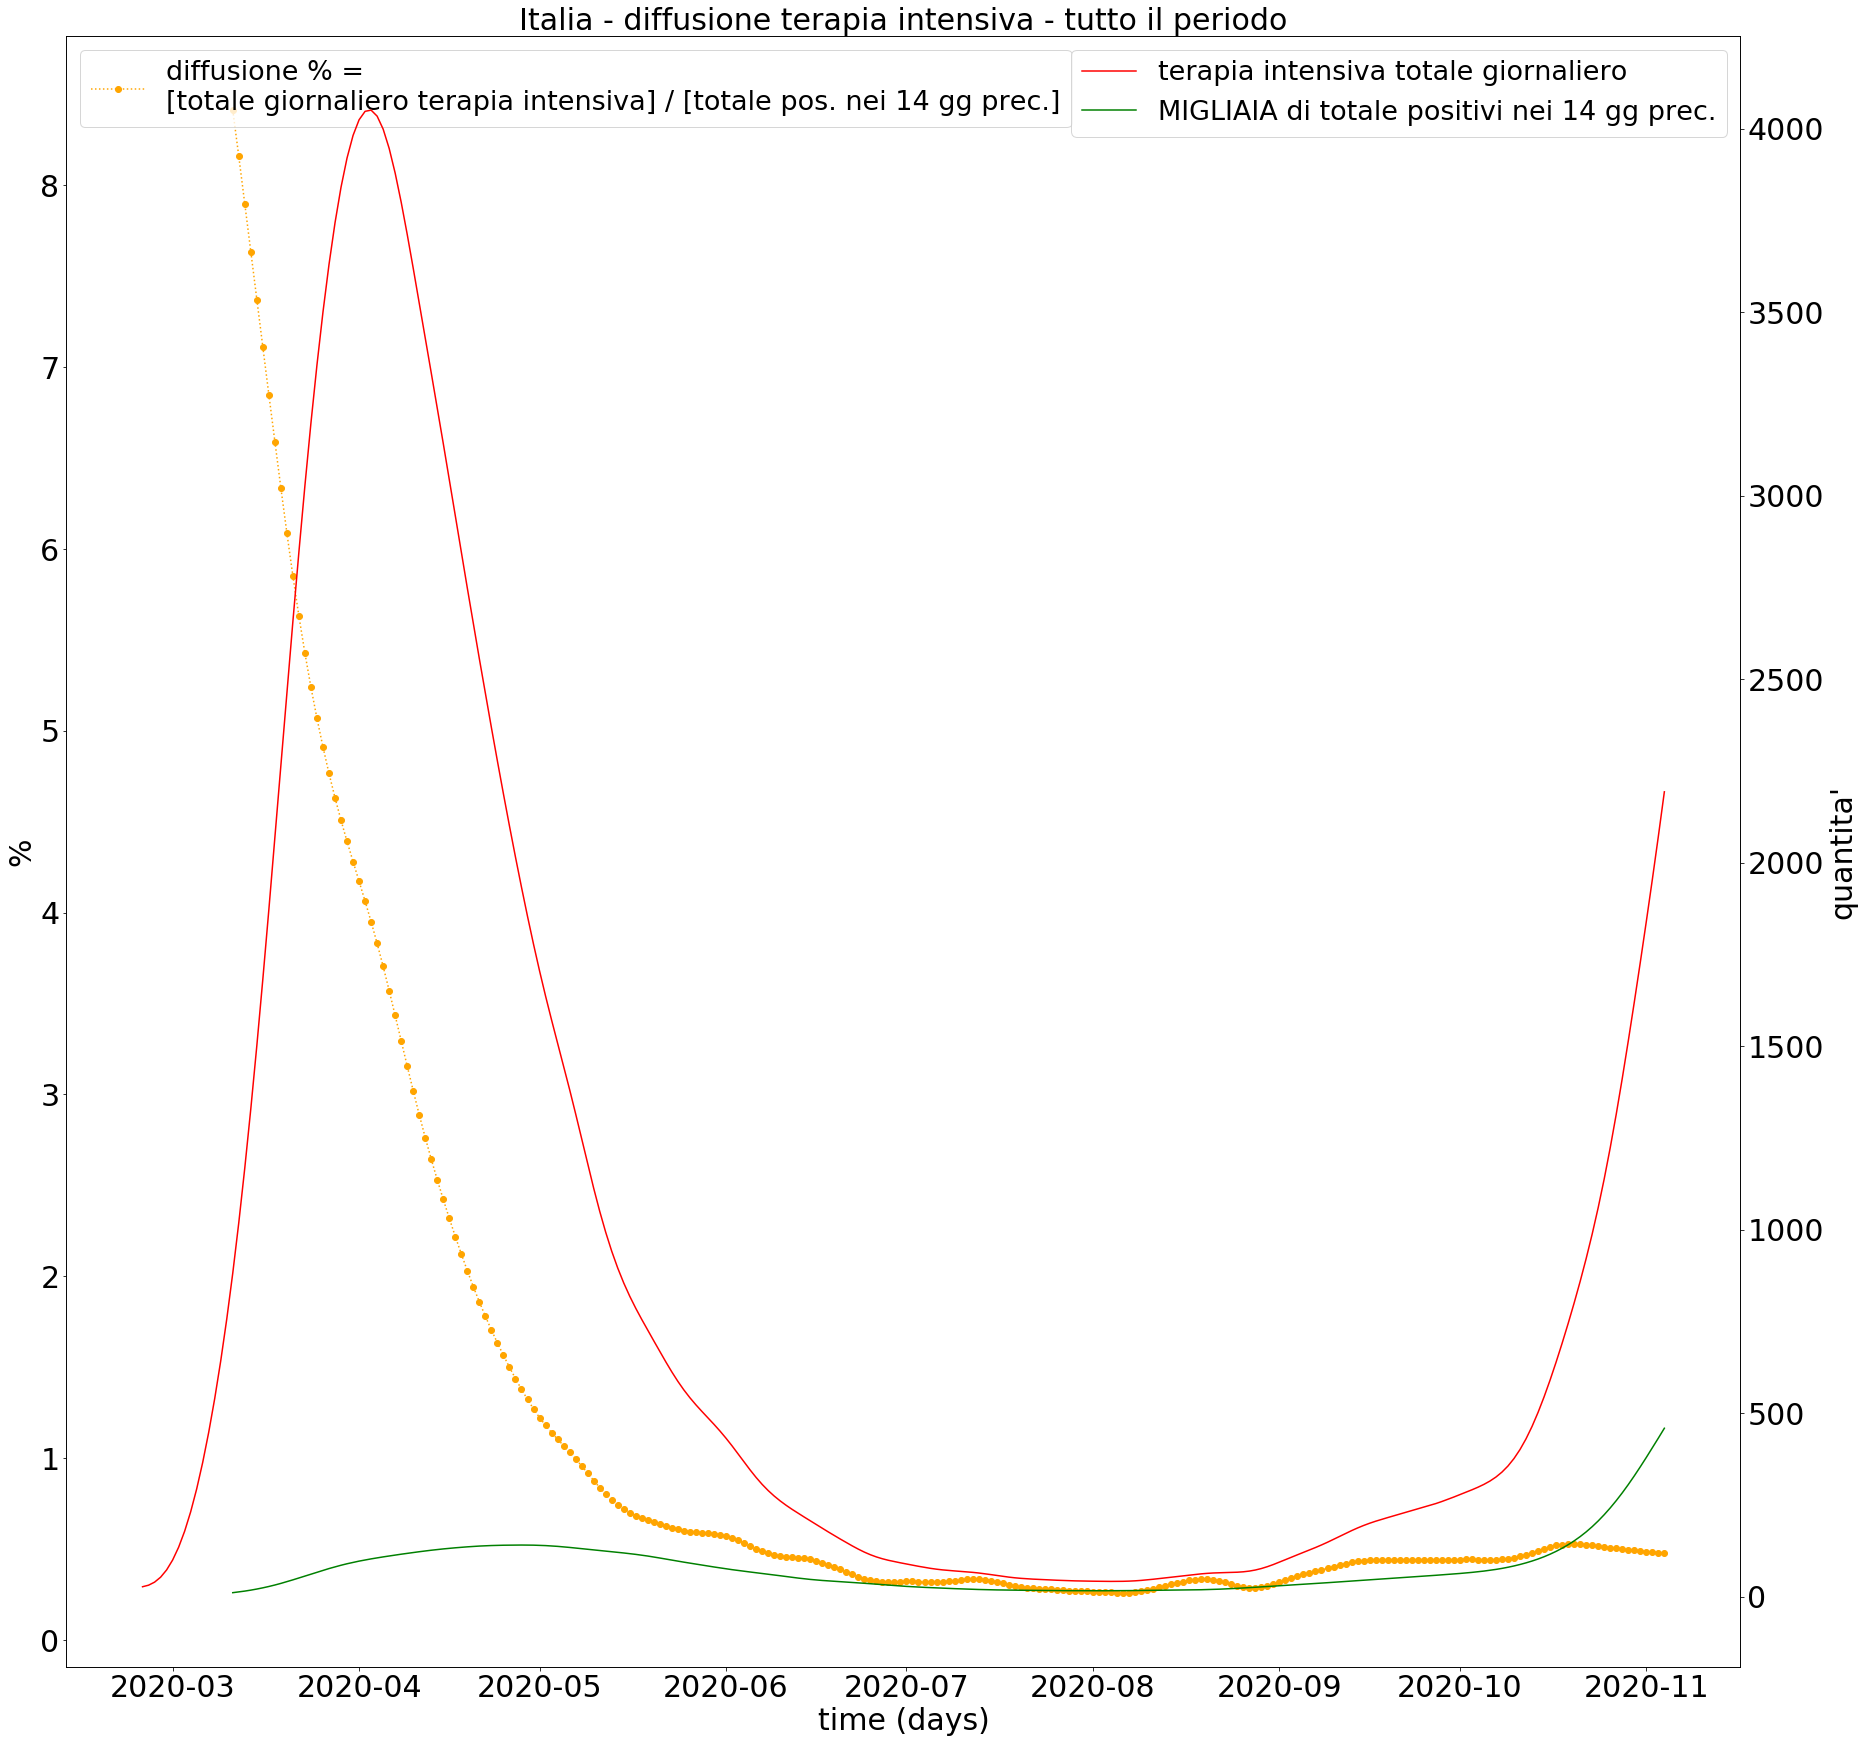

In [46]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,30))
ax1.set_title('Italia - diffusione terapia intensiva - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)

ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_terapia_intensiva_su_totale_positivi_in_14_smoothed*100, label='diffusione % = \n[totale giornaliero terapia intensiva] / [totale pos. nei 14 gg prec.]', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed, label='terapia intensiva totale giornaliero', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/1000, label='MIGLIAIA di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')

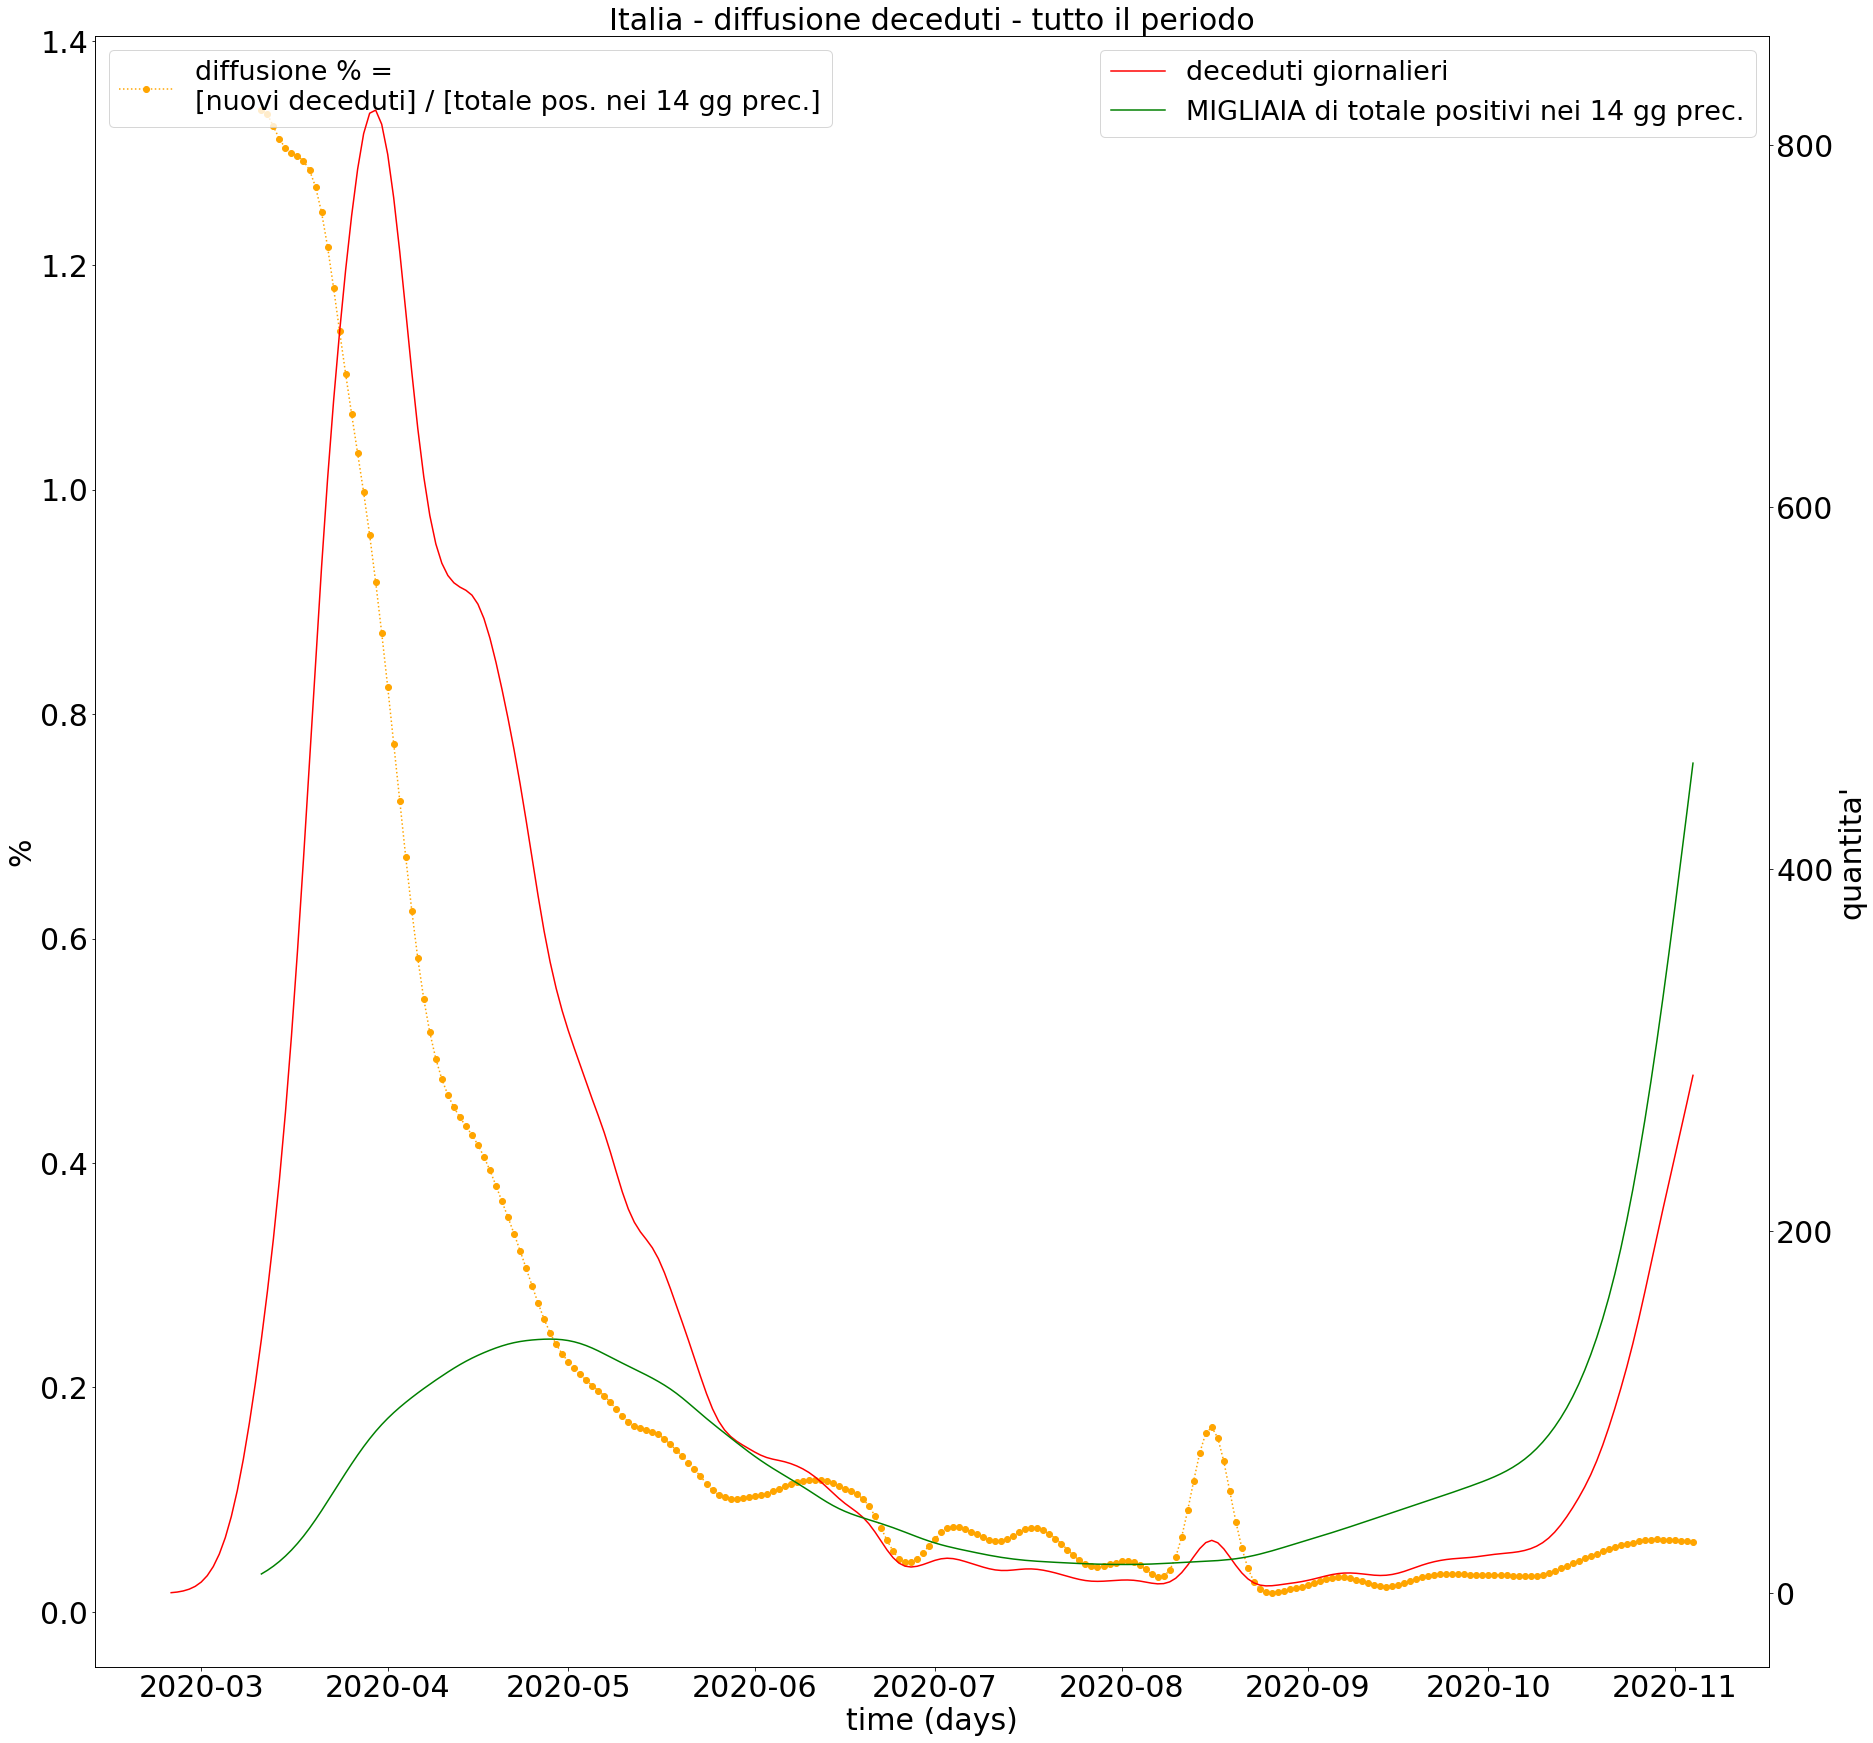

In [47]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,30))
ax1.set_title('Italia - diffusione deceduti - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)

ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_deceduti_su_totale_positivi_in_14_smoothed*100, label='diffusione % = \n[nuovi deceduti] / [totale pos. nei 14 gg prec.]', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.deceduti_giornalieri_smoothed, label='deceduti giornalieri', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/1000, label='MIGLIAIA di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')

# checking tamponi vs dimessi

In [48]:
start, end = 20, TIMESTEPS

td_offset, td_corrs = compute_offset(
    s_preceeding=italy_raw_data.tamponi_giornalieri_smoothed[start:end],
    s_following=italy_raw_data.dimessi_guariti_giornalieri_smoothed[start:end], 
    start=-5, interval=10
)


tod, tod_e = compute_average_ratio(
    italy_raw_data.tamponi_giornalieri_smoothed.shift(td_offset)[start:end], 
    italy_raw_data.dimessi_guariti_giornalieri_smoothed[start:end]
)

print('tamponi dimessi, offset: {}, ratio: {:2.0f} +/- {:2.0f}'.format(td_offset, tod, tod_e))


tamponi dimessi, offset: -2, ratio: 100 +/- 83


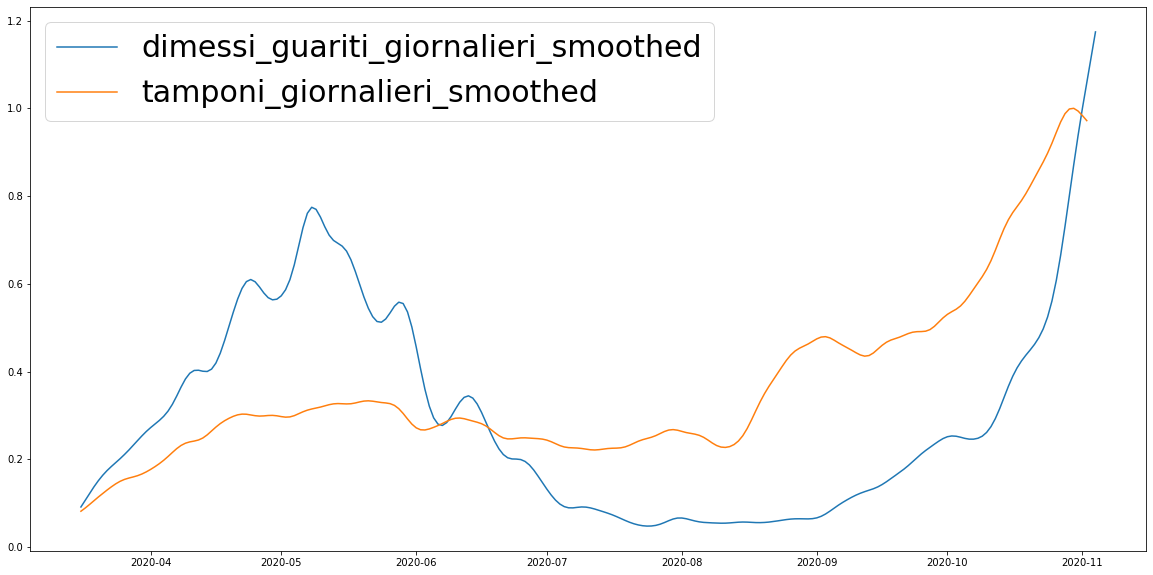

In [49]:
start, end = 20, TIMESTEPS
shift = 3
plt.figure(figsize=(20,10))
plt.plot(
    italy_raw_data.data[start:end], 
    italy_raw_data.dimessi_guariti_giornalieri_smoothed[start:end]/italy_raw_data.dimessi_guariti_giornalieri_smoothed.shift(3)[start:end].max(), label='dimessi_guariti_giornalieri_smoothed'
)
plt.plot(
    italy_raw_data.data[start:end], 
    italy_raw_data.tamponi_giornalieri_smoothed.shift(td_offset)[start:end]/italy_raw_data.tamponi_giornalieri_smoothed[start:end].max(), label='tamponi_giornalieri_smoothed'
)


plt.legend(fontsize=30)

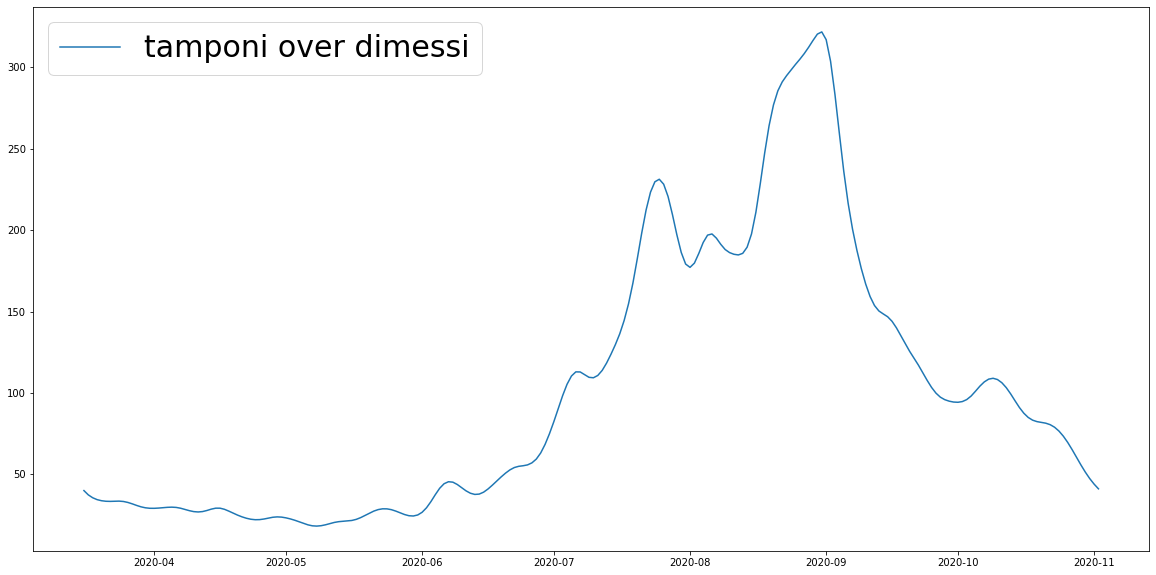

In [50]:
plt.figure(figsize=(20,10))
plt.plot(italy_raw_data.data[start:end], italy_raw_data.tamponi_giornalieri_smoothed.shift(td_offset)[start:end]/italy_raw_data.dimessi_guariti_giornalieri_smoothed[start:end], label='tamponi over dimessi')


plt.legend(fontsize=30)

# Doubling time

In [51]:
def doubling_times(x):
    Td = []
    for idx, tp in x.items():
        td = np.argmax(x > 2. * tp)
        if td > 0:
            Td.append(td -idx)
        else:
            Td.append(np.nan)
    return np.array(Td)

In [52]:
italy_raw_data['totale_positivi_Dt'] = doubling_times(italy_raw_data.totale_positivi)

In [53]:
italy_raw_data['totale_positivi_smoothed_Dt'] = doubling_times(italy_raw_data.totale_positivi_smoothed)

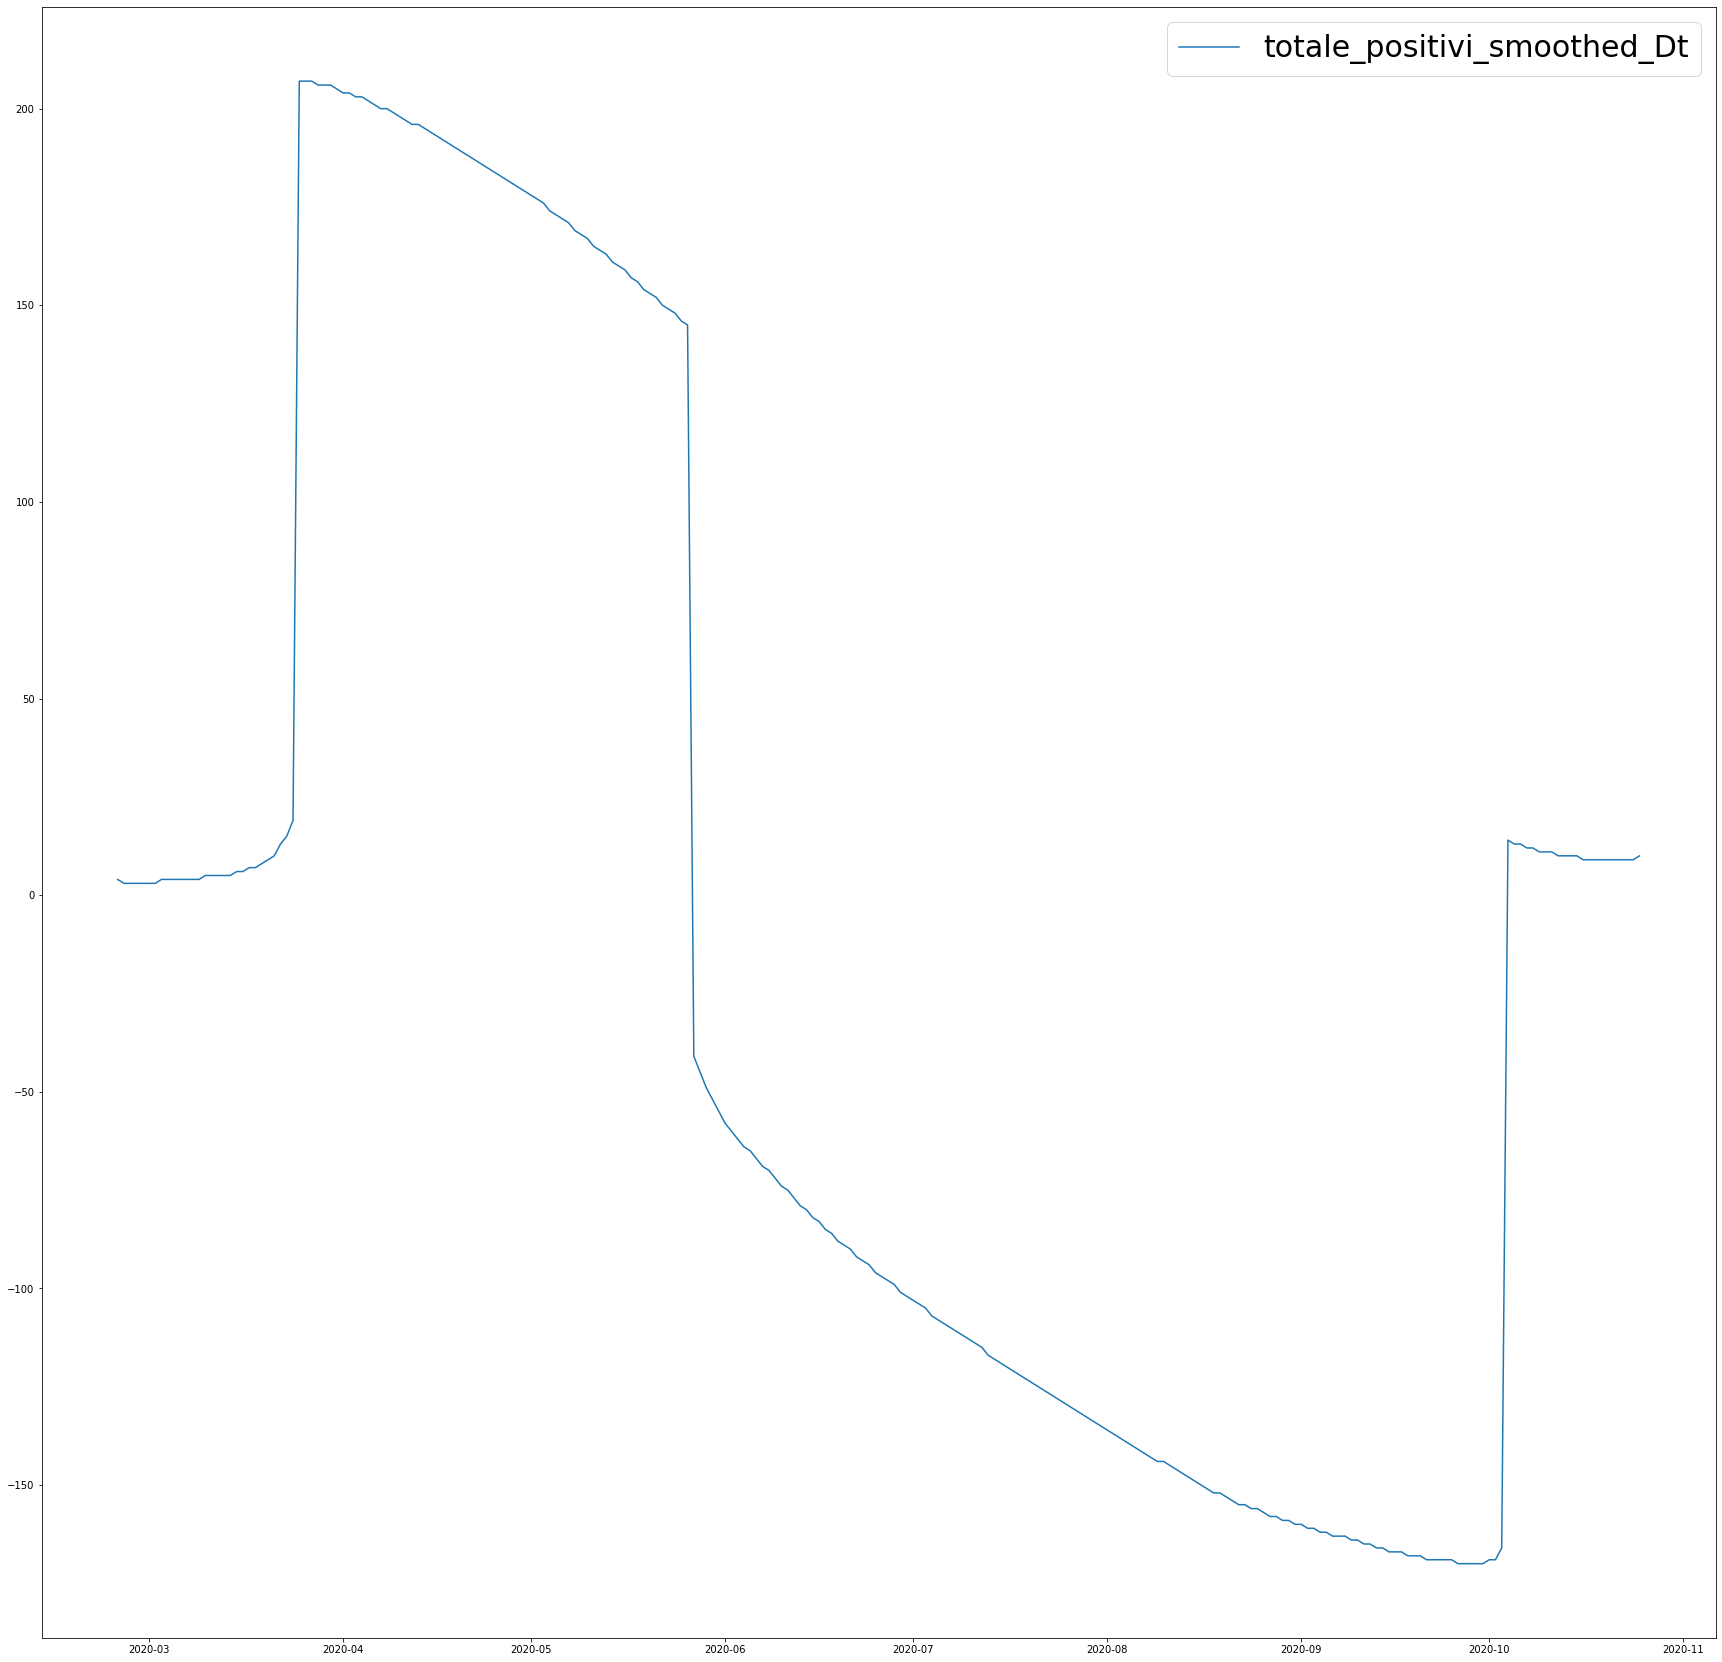

In [54]:
plt.figure(figsize=(30,30))

plt.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed_Dt, label='totale_positivi_smoothed_Dt')

plt.legend(fontsize=30)

## fitting the doubling time among 5 moving points

In [55]:
def fitted_doubling_time(x):
    fit_points = 5
    stop_before = 0
    half_interval = int(fit_points / 2)
    stop_at = TIMESTEPS - half_interval - stop_before

    double_times = [np.nan] * half_interval
    for idx, tp in x.items():
        time_range = np.array(range(0,fit_points)).reshape(fit_points, 1)
        if idx > half_interval and idx < stop_at:
            interval_points = x[idx-half_interval:idx+half_interval+1].to_numpy()
            reg = LinearRegression().fit(time_range, interval_points)
            Dt = 2 * tp / reg.coef_[0]
            double_times.append(Dt)

    double_times = double_times + [np.nan] * (TIMESTEPS - stop_at +1)
    return np.array(double_times).reshape(TIMESTEPS, 1)


In [56]:
italy_raw_data['totale_positivi_Dt_fit'] = fitted_doubling_time(italy_raw_data.totale_positivi)
italy_raw_data['totale_positivi_smoothed_Dt_fit'] = fitted_doubling_time(italy_raw_data.totale_positivi_smoothed)

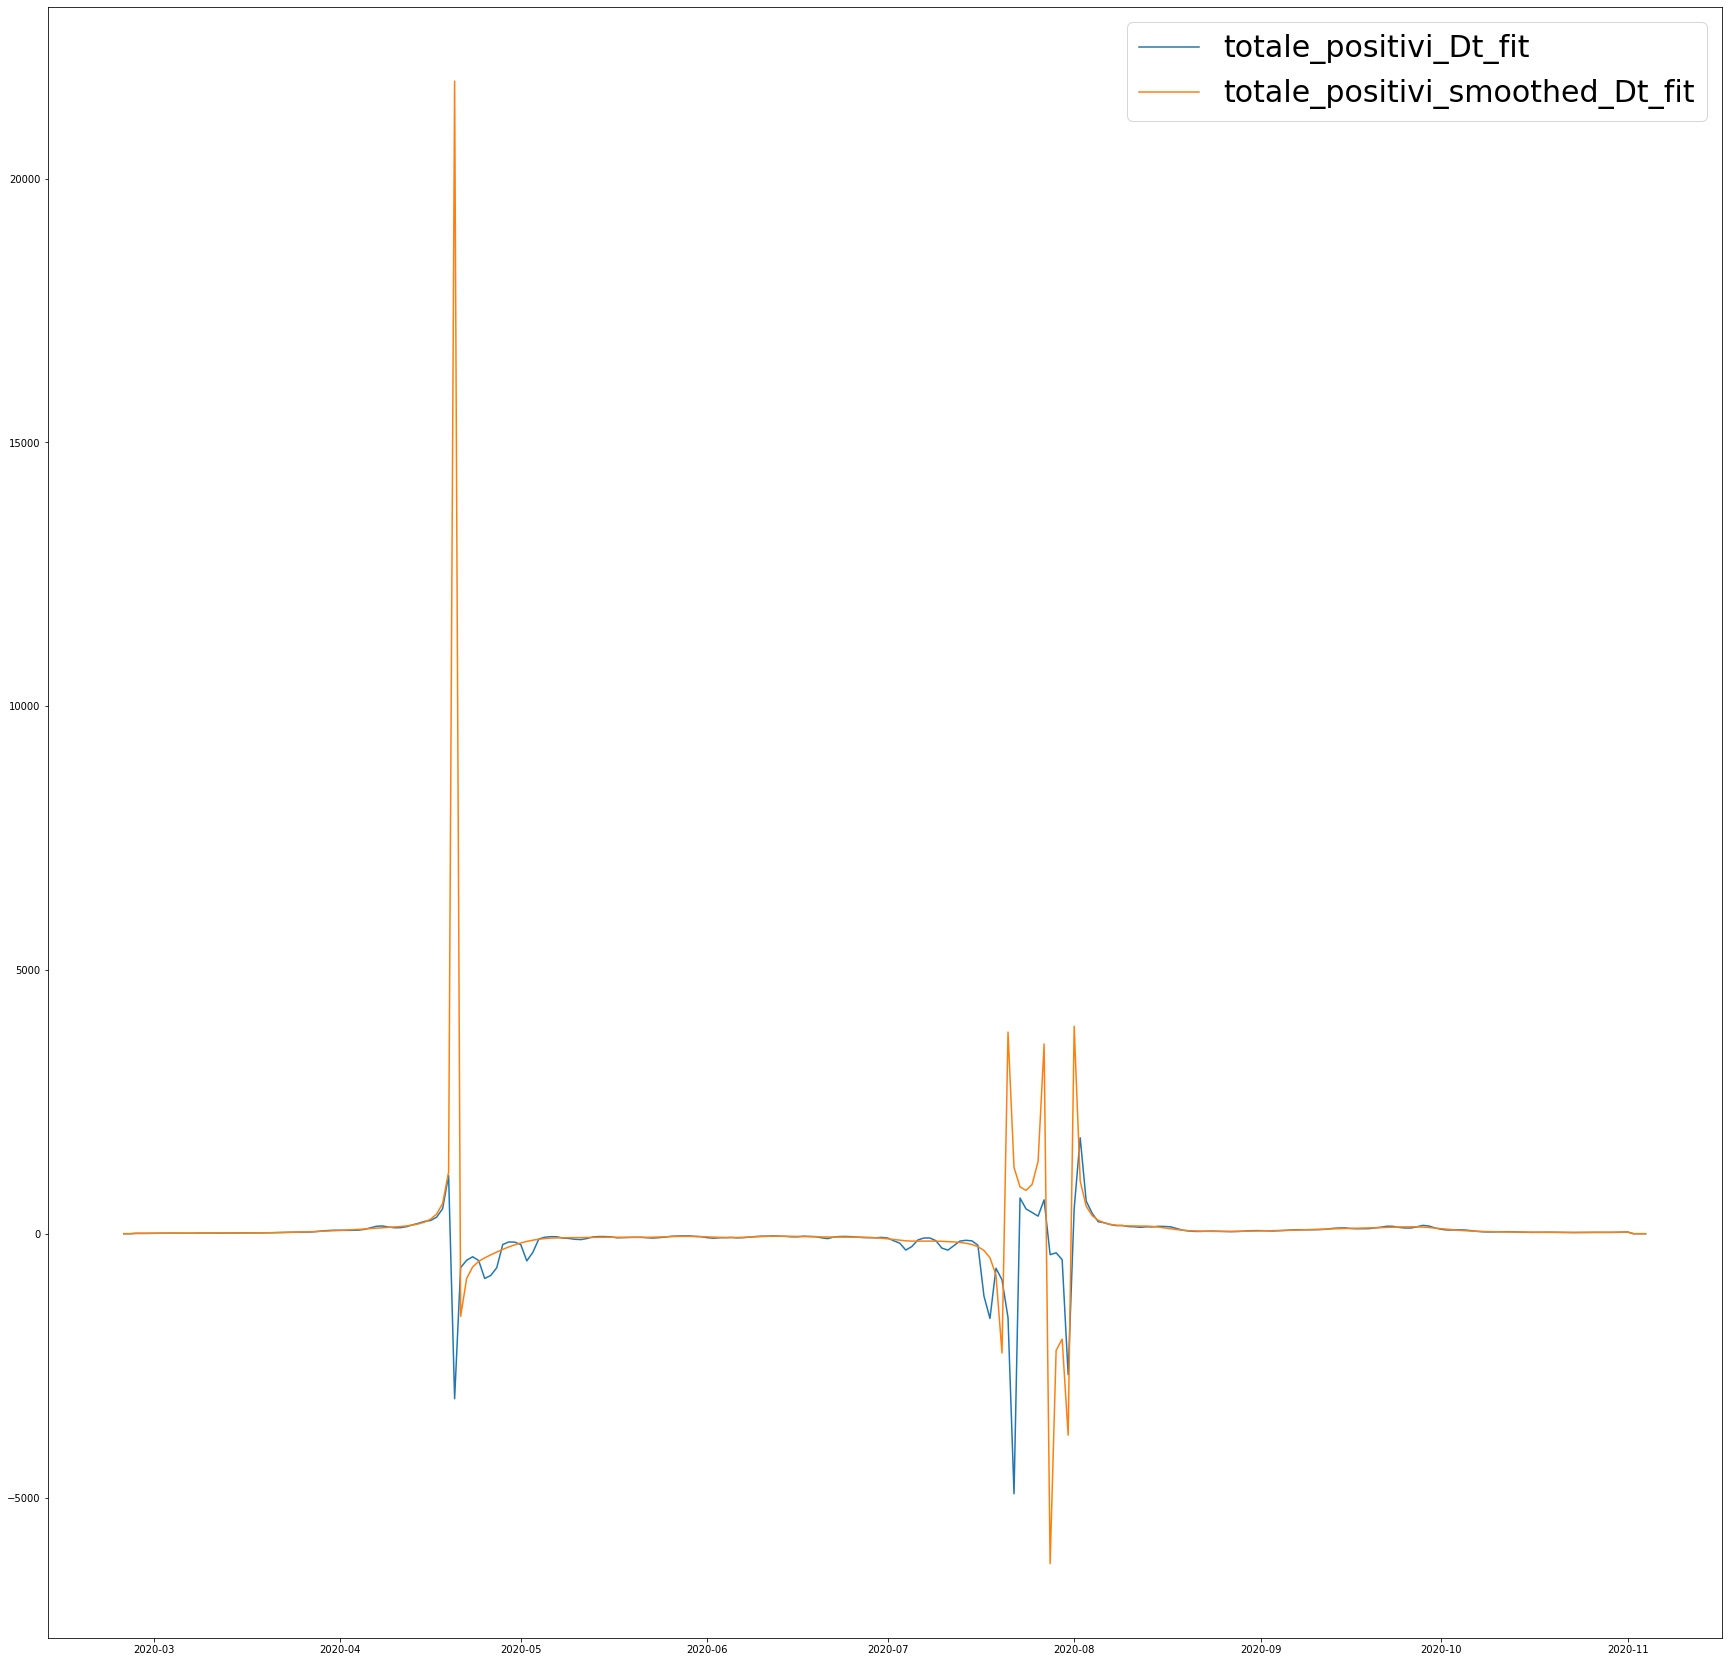

In [57]:
plt.figure(figsize=(30,30))
#plt.yscale('log')
plt.plot(italy_raw_data.data, italy_raw_data.totale_positivi_Dt_fit.fillna(0), label='totale_positivi_Dt_fit')
plt.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed_Dt_fit.fillna(0), label='totale_positivi_smoothed_Dt_fit')
#plt.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed/10**2, label='totale_positivi_smoothed')


plt.legend(fontsize=30)

In [58]:
italy_raw_data['totale_casi_Dt_fit'] = fitted_doubling_time(italy_raw_data.totale_casi)
italy_raw_data['totale_casi_smoothed_Dt_fit'] = fitted_doubling_time(italy_raw_data.totale_casi_smoothed)


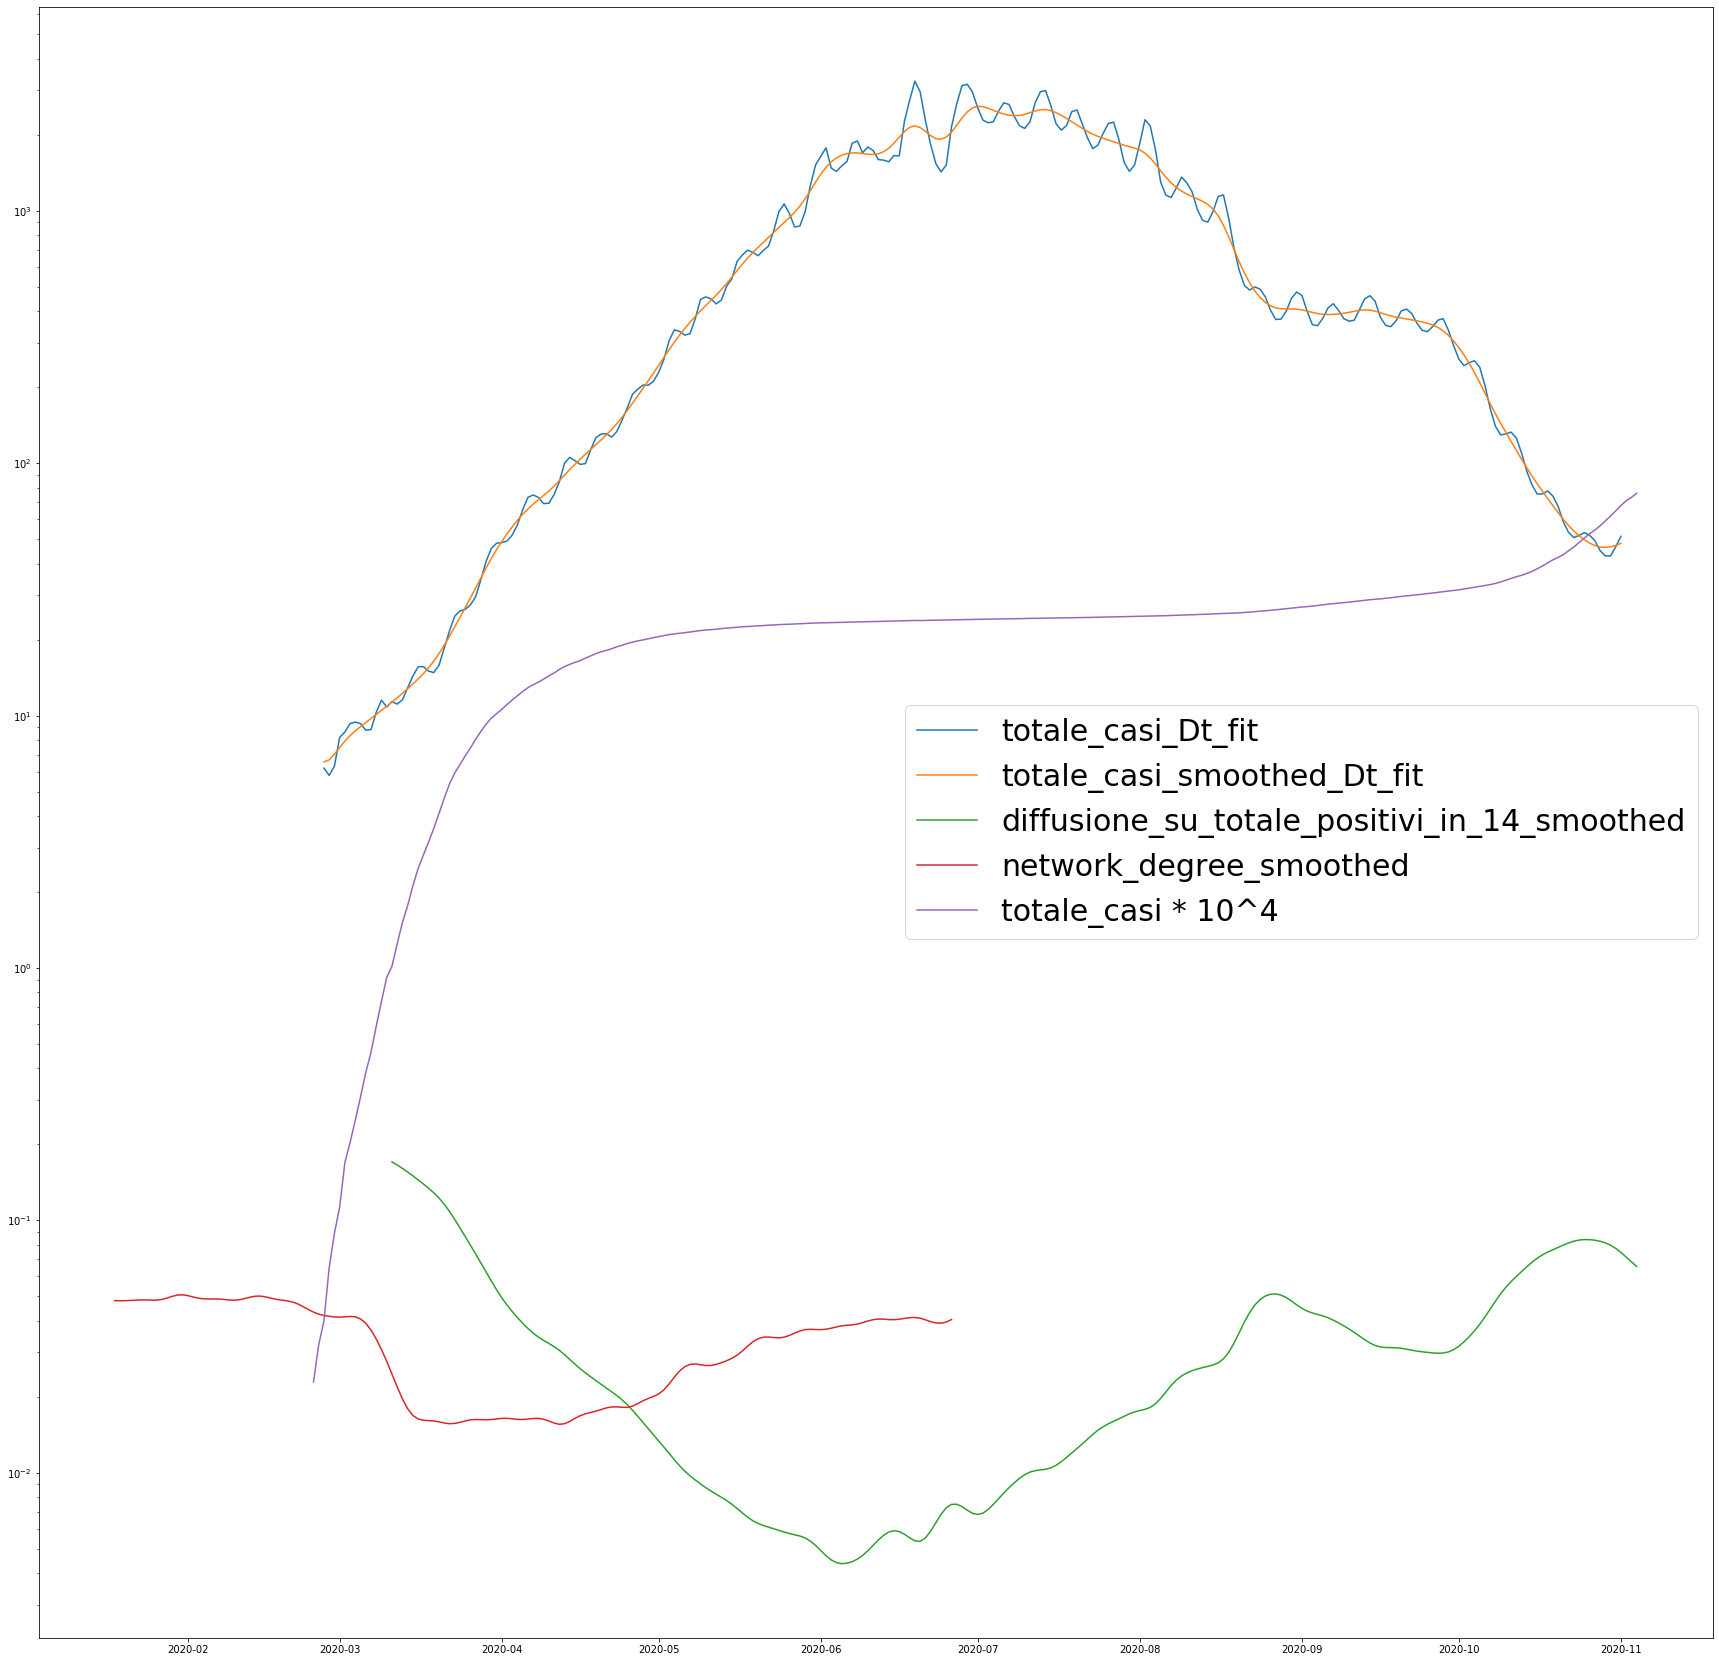

In [59]:
plt.figure(figsize=(30,30))
plt.yscale('log')
plt.plot(italy_raw_data.data, italy_raw_data.totale_casi_Dt_fit, label='totale_casi_Dt_fit')
plt.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_Dt_fit, label='totale_casi_smoothed_Dt_fit')

plt.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed, label='diffusione_su_totale_positivi_in_14_smoothed')
plt.plot(italy_mobility_data.date, italy_mobility_data.network_degree_smoothed, label='network_degree_smoothed')

plt.plot(italy_raw_data.data, italy_raw_data.totale_casi/10**4, label='totale_casi * 10^4')


plt.legend(fontsize=30)

In [67]:
### Doubling time of total cases

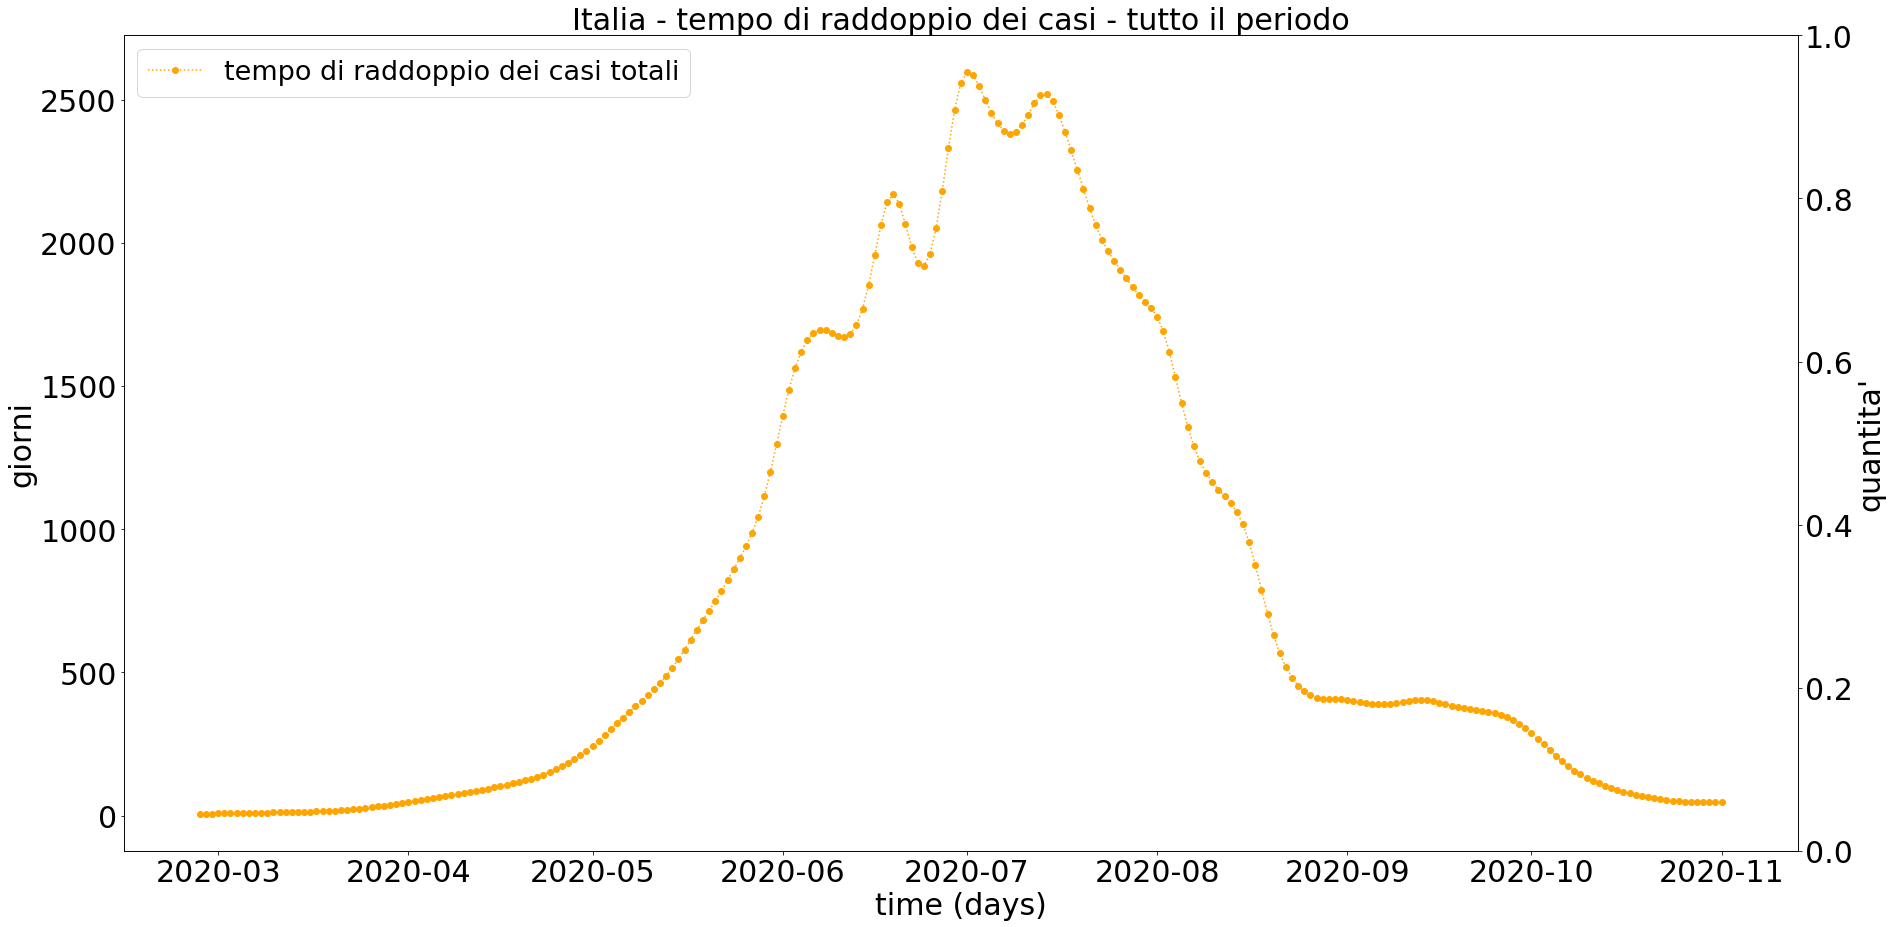

In [63]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio dei casi - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)

ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_Dt_fit, label='tempo di raddoppio dei casi totali', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

#ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

#ax2.legend(fontsize=27,loc='upper right')

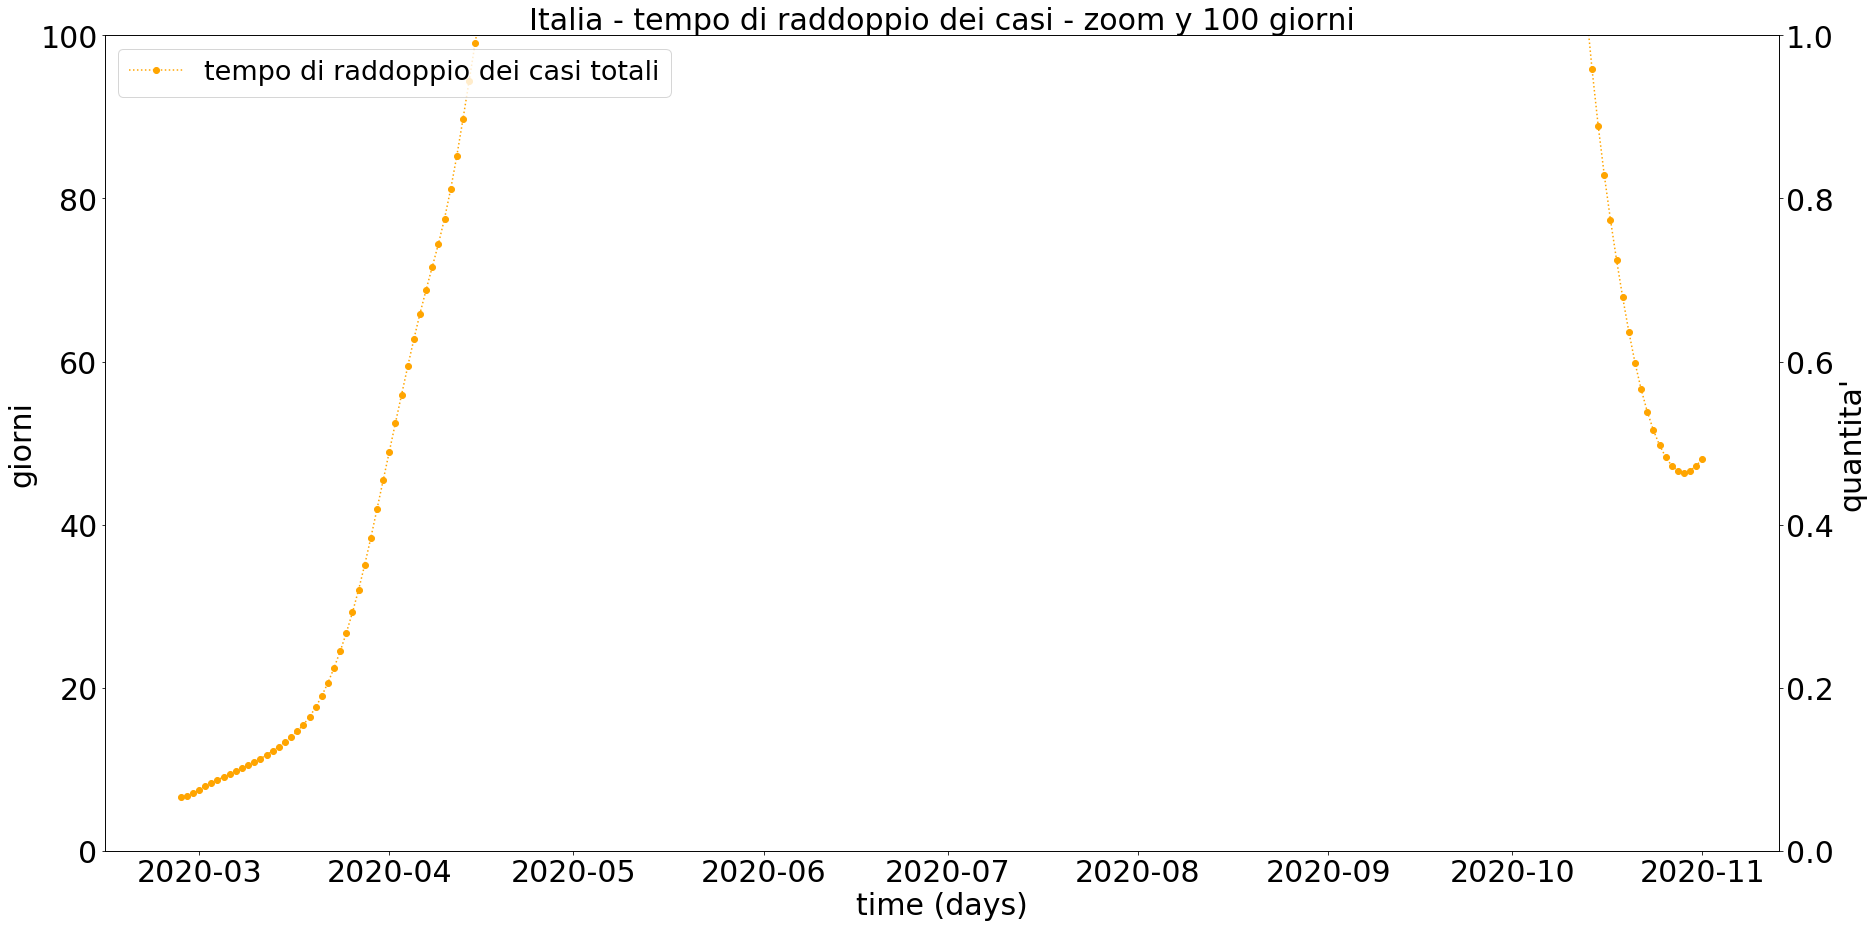

In [66]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio dei casi - zoom y 100 giorni', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,100)
ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_Dt_fit, label='tempo di raddoppio dei casi totali', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

#ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

#ax2.legend(fontsize=27,loc='upper right')

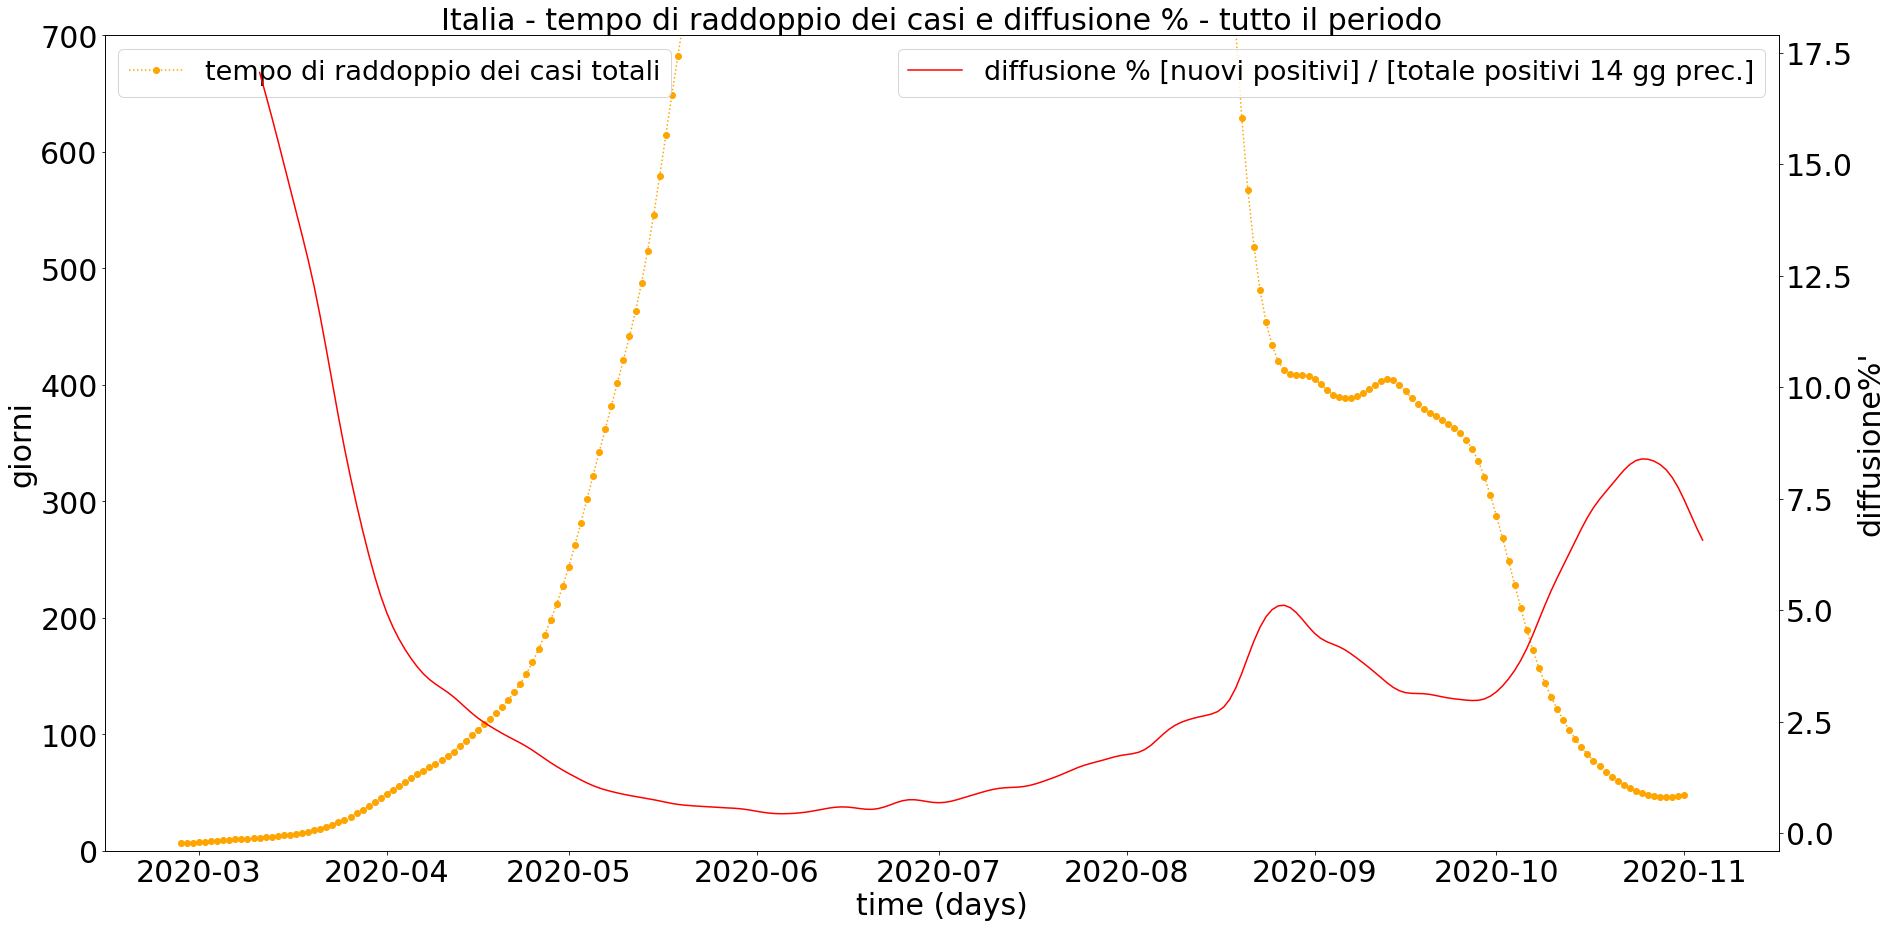

In [71]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio dei casi e diffusione % - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,700)
ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_Dt_fit, label='tempo di raddoppio dei casi totali', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('diffusione%\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed*100, label='diffusione % [nuovi positivi] / [totale positivi 14 gg prec.]', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')

In [73]:
italy_raw_data['deceduti_smoothed_Dt_fit'] = fitted_doubling_time(italy_raw_data.deceduti_smoothed)
italy_raw_data['terapia_intensiva_smoothed_Dt_fit'] = fitted_doubling_time(italy_raw_data.terapia_intensiva_smoothed)

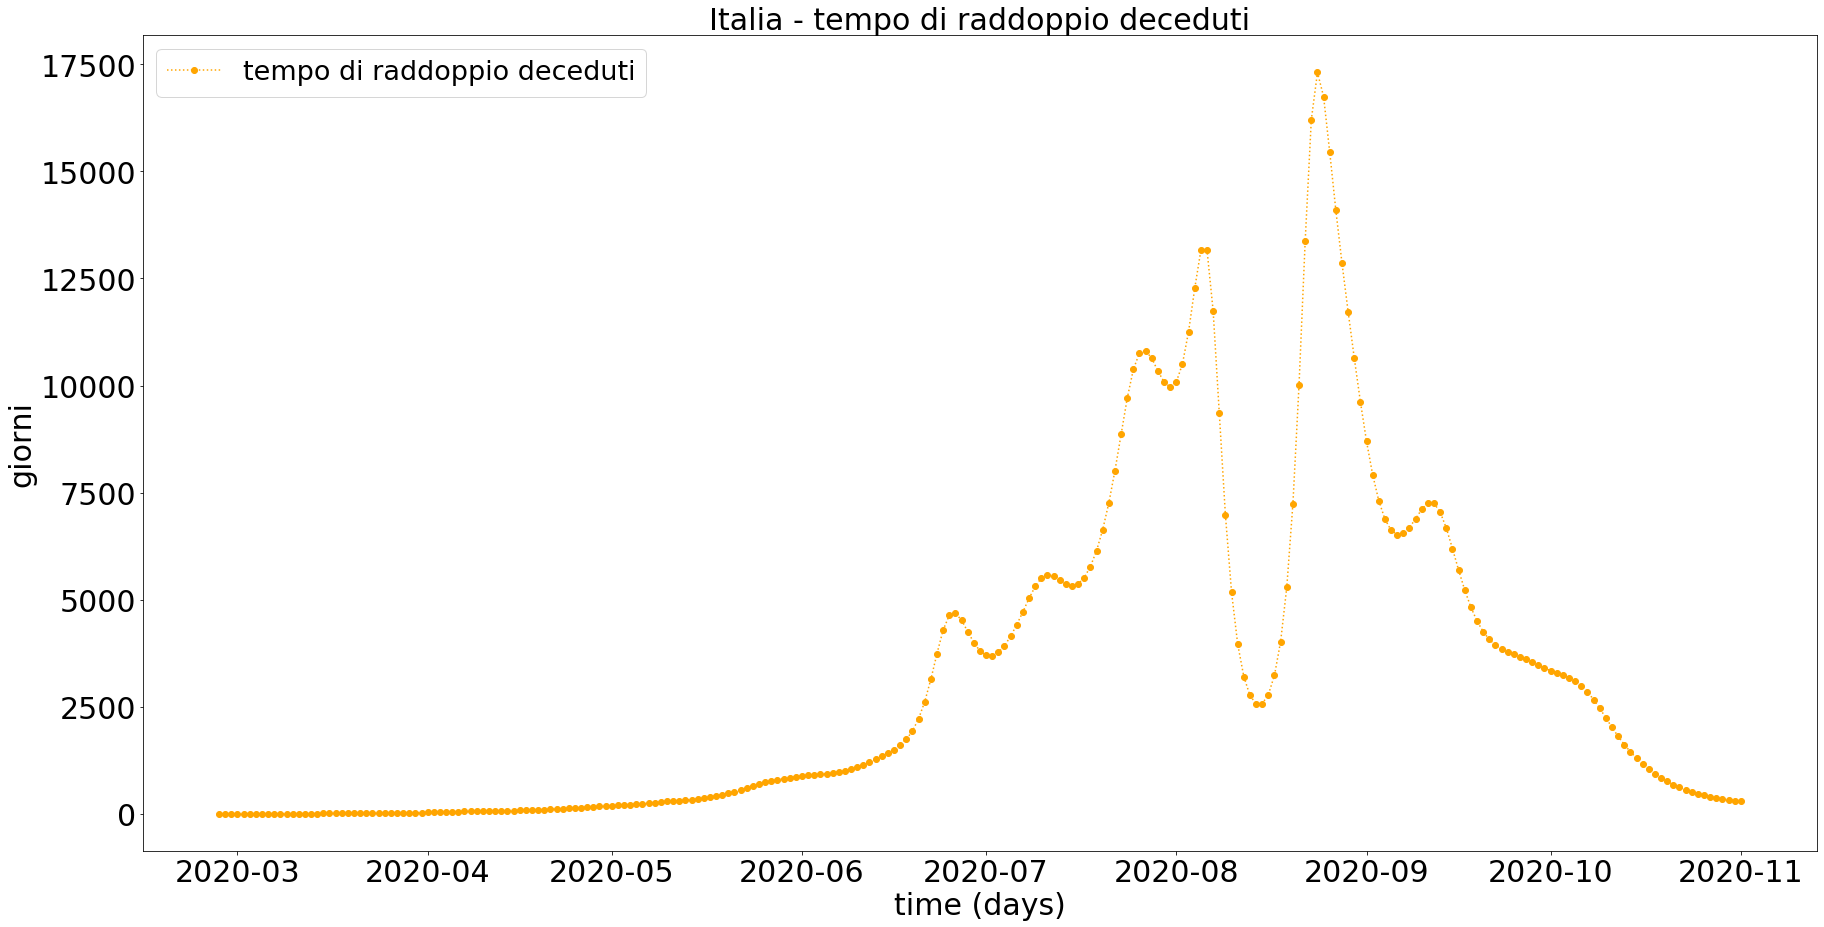

In [77]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio deceduti', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
#ax1.set_ylim(0,100)
ax1.plot(italy_raw_data.data, italy_raw_data.deceduti_smoothed_Dt_fit, label='tempo di raddoppio deceduti', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


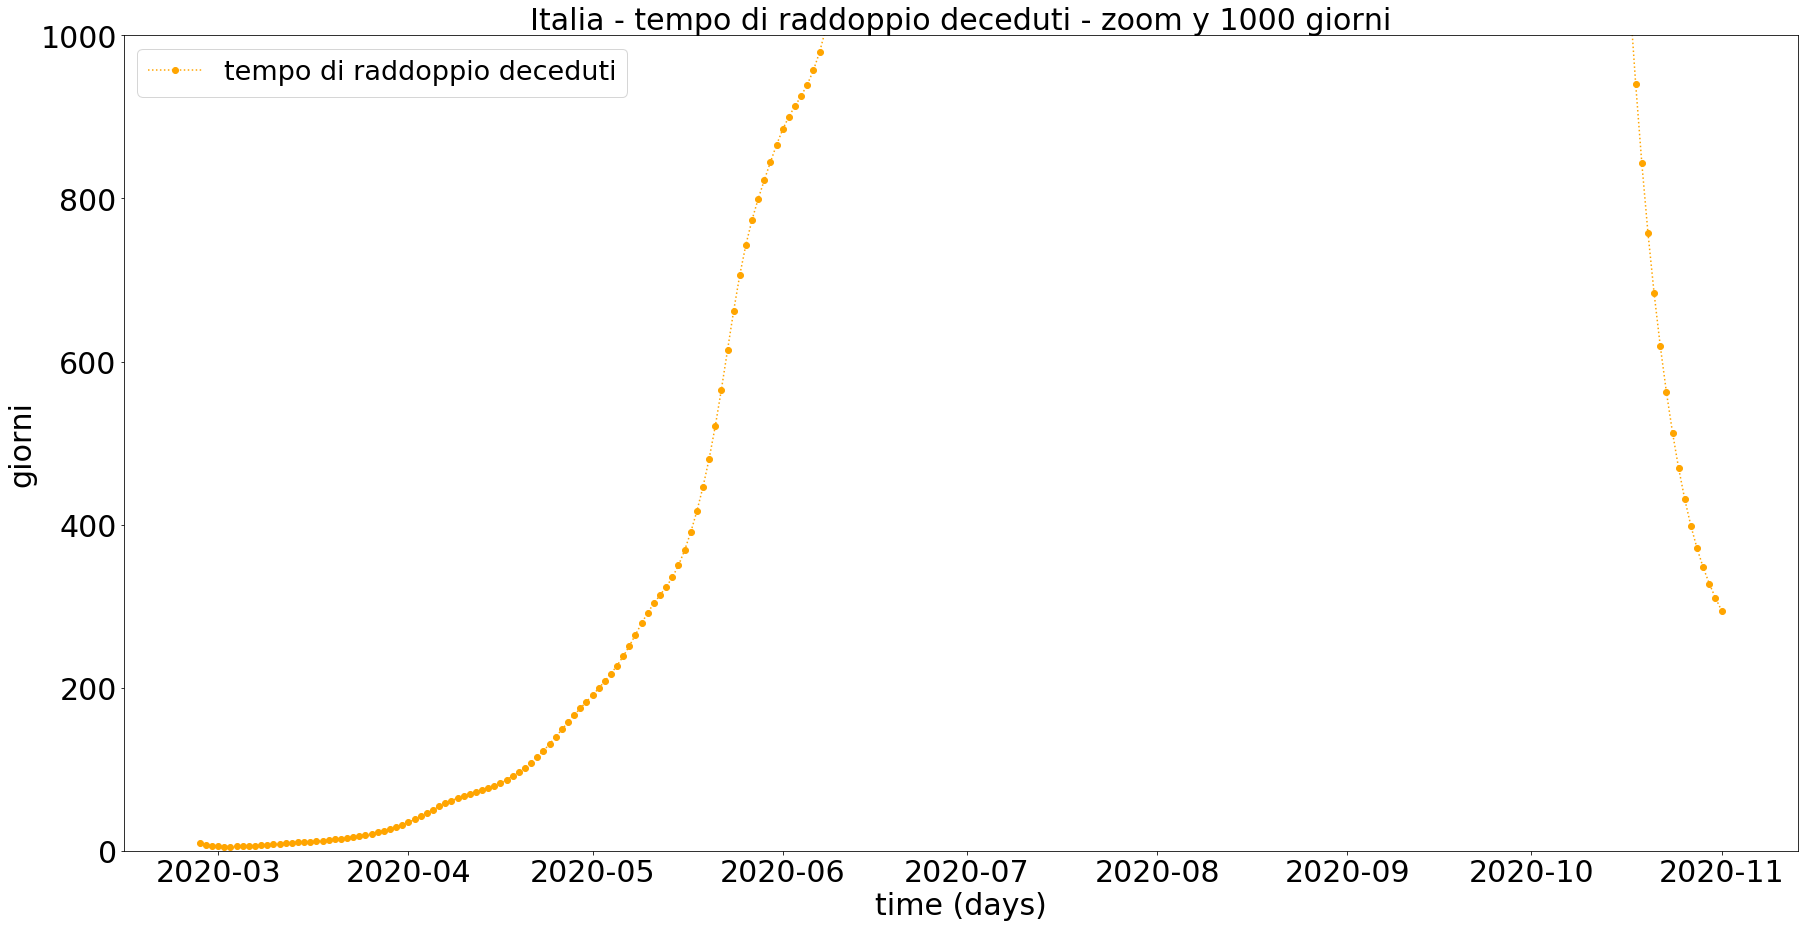

In [79]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio deceduti - zoom y 1000 giorni', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,1000)
ax1.plot(italy_raw_data.data, italy_raw_data.deceduti_smoothed_Dt_fit, label='tempo di raddoppio deceduti', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')
